In [1]:
from torch import nn

class PhoneDetectorModel(nn.Module):
    def __init__(self):
        super(PhoneDetectorModel, self).__init__()
        self.enc_conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.enc_conv2 = nn.Conv2d(8, 32, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 128, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.enc_conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.enc_conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.enc_conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=2)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.relu = nn.ReLU()

        self.linear_1 = nn.LazyLinear(256)
        self.bn7 = nn.BatchNorm1d(256)
        self.linear_2 = nn.Linear(256, 1)
        
    def forward(self, X):
        X = self.relu(self.bn1(self.enc_conv1(X)))
        X = self.relu(self.bn2(self.enc_conv2(X)))
        X = self.relu(self.bn3(self.enc_conv3(X)))
        X = self.relu(self.bn4(self.enc_conv4(X)))  # Added ReLU activation here
        X = self.relu(self.bn5(self.enc_conv5(X)))
        X = self.relu(self.bn6(self.enc_conv6(X)))  # Added ReLU activation here

        X = X.flatten(start_dim=1)

        X = self.relu(self.bn7(self.linear_1(X)))
        X = self.linear_2(X)
        return X

In [24]:
from collections import deque
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import os


class phone_detector():
    def __init__(self, model_path, phone_window_size=30):
        self.model = PhoneDetectorModel()
        self.model.load_state_dict(torch.load(model_path))
        self.phone_window = deque(maxlen=phone_window_size)
    
    def detect_phone(self, frame):
        image = Image.fromarray(frame)
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image = transform(image).unsqueeze(0)
        self.model.eval()

        with torch.no_grad():
            output = self.model(image)
            prob = torch.sigmoid(output)
            pred = (prob > 0.5).float().item()
        self.phone_window.append(int(pred))
        return int(pred)
    
    def phone_duration(self):
        if len(self.phone_window) < 30:
            return 0
        phone_count = sum(self.phone_window)
        return phone_count / len(self.phone_window)
    
    def calculate_phone_feature(self, frame, frame_id):
    
        phone_feature = self.detect_phone(frame)
        phone_duration = self.phone_duration()
        return {"phone_presence": phone_feature, "phone_duration": phone_duration}


In [3]:
import pandas as pd

df = pd.DataFrame(columns=["frame_id", "phone_presence", "phone_duration"])
def process_video(video_path, model_path):
    detector = phone_detector(model_path)
    cap = cv2.VideoCapture(video_path)
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        phone_feature = detector.calculate_phone_feature(frame, frame_id)
        df.loc[frame_id] = [frame_id, phone_feature["phone_presence"], phone_feature["phone_duration"]]
        frame_id += 1

    cap.release()
    return df

In [4]:
process_video("/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/phone_20.mp4",
               "/home/harsh/Downloads/sem2/edgeai/edge ai project/phone_detector_model_final.pt")

df

frame_id  phone_presence  phone_duration
0         0.0             1.0             0.0
1         1.0             1.0             0.0
2         2.0             1.0             0.0
3         3.0             1.0             0.0
4         4.0             1.0             0.0
..        ...             ...             ...
895     895.0             1.0             1.0
896     896.0             1.0             1.0
897     897.0             1.0             1.0
898     898.0             1.0             1.0
899     899.0             1.0             1.0

[900 rows x 3 columns]

In [5]:
df = pd.DataFrame(columns=["frame_id", "phone_presence", "phone_duration"])

process_video("/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/normal_5.mp4",
               "/home/harsh/Downloads/sem2/edgeai/edge ai project/phone_detector_model_final.pt")

df

frame_id  phone_presence  phone_duration
0         0.0             1.0             0.0
1         1.0             1.0             0.0
2         2.0             1.0             0.0
3         3.0             1.0             0.0
4         4.0             1.0             0.0
..        ...             ...             ...
895     895.0             1.0             1.0
896     896.0             1.0             1.0
897     897.0             1.0             1.0
898     898.0             1.0             1.0
899     899.0             1.0             1.0

[900 rows x 3 columns]

In [26]:
from collections import deque
import numpy as np

class eye_features():
    def __init__(self, frame_width, frame_height, mar_threshold, perclos_threshold):
        self.mar_threshold = mar_threshold
        self.perclos_threshold = perclos_threshold
        self.frame_width = frame_width
        self.frame_height = frame_height
        
        # Window sizes
        self.ear_window_size = 150  # 5 sec @ 30fps
        self.perclos_window_size = 150
        self.blink_window_size = 150
        self.pupil_movement_window_size = 30
        
        # Initialize windows using deques
        self.perclos_window = deque(maxlen=self.perclos_window_size)
        self.blink_window = deque(maxlen=self.blink_window_size)
        self.ear_window = deque(maxlen=self.ear_window_size)
        self.left_pupil_distance_window = deque(maxlen=self.pupil_movement_window_size)
        self.right_pupil_distance_window = deque(maxlen=self.pupil_movement_window_size)

    @staticmethod
    def get_mouth_landmarks(face_results, frame_width=640, frame_height=480):
        mouth_landmarks = []
        if face_results.multi_face_landmarks:
            for face_landmakrs in face_results.multi_face_landmarks:
                mouth_landmarks = [
                    face_landmakrs.landmark[67],  # Right Corner of LiP
                    face_landmakrs.landmark[73],  # Right top of LiP
                    face_landmakrs.landmark[11],  # Top of LIP
                    face_landmakrs.landmark[303],  # Left top of LiP
                    face_landmakrs.landmark[61],  # Left Corner of Lip
                    face_landmakrs.landmark[403],  # Left Bottom of LiP
                    face_landmakrs.landmark[16],  # Bottom of LiP
                    face_landmakrs.landmark[180],  # Right Bottom of LiP
                ]
                mouth_landmarks = [(lm.x * frame_width, lm.y * frame_height, lm.z) for lm in mouth_landmarks]
                return mouth_landmarks
        return None

    @staticmethod
    def get_eye_landmarks(face_results, frame_width=640, frame_height=480):
        left_eye_landmarks = []
        right_eye_landmarks = []
        left_pupil_landmarks = []
        right_pupil_landmarks = []

        if face_results.multi_face_landmarks:
            for face_landmarks in face_results.multi_face_landmarks:
                left_eye_landmarks = [
                    face_landmarks.landmark[33],  # left most point # p1
                    face_landmarks.landmark[133],  # right most point # p4
                    face_landmarks.landmark[160],  # top left point # p2
                    face_landmarks.landmark[158],  # top right point # p3
                    face_landmarks.landmark[144],  # bottom left point # p6
                    face_landmarks.landmark[153],  # bottom right point # p5
                ]

                right_eye_landmarks = [
                    face_landmarks.landmark[362],  # left most point
                    face_landmarks.landmark[263],  # right most point
                    face_landmarks.landmark[385],  # top left point
                    face_landmarks.landmark[387],  # top right point
                    face_landmarks.landmark[380],  # bottom left point
                    face_landmarks.landmark[373],  # bottom right point
                ]

                left_pupil_landmarks = [
                    face_landmarks.landmark[469],  # right most point
                    face_landmarks.landmark[470],  # top point
                    face_landmarks.landmark[471],  # left most point
                    face_landmarks.landmark[472],  # bottom point
                ]

                right_pupil_landmarks = [
                    face_landmarks.landmark[474],  # right most point
                    face_landmarks.landmark[475],  # top point
                    face_landmarks.landmark[476],  # left most point
                    face_landmarks.landmark[477],  # bottom point
                ]
                # Convert landmarks to list
                left_eye_landmarks = [(landmark.x * frame_width, landmark.y * frame_height, landmark.z) for landmark in
                                     left_eye_landmarks]
                right_eye_landmarks = [(landmark.x * frame_width, landmark.y * frame_height, landmark.z) for landmark in
                                      right_eye_landmarks]
                left_pupil_landmarks = [(landmark.x * frame_width, landmark.y * frame_height, landmark.z) for landmark in
                                       left_pupil_landmarks]
                right_pupil_landmarks = [(landmark.x * frame_width, landmark.y * frame_height, landmark.z) for landmark in
                                        right_pupil_landmarks]

        return left_eye_landmarks, right_eye_landmarks, left_pupil_landmarks, right_pupil_landmarks

    @staticmethod
    def no_visible_eyes(face_results):
        if not face_results.multi_face_landmarks:
            return True
        for face_landmarks in face_results.multi_face_landmarks:
            left_eye_visible = face_landmarks.landmark[33].visibility > 0.5
            right_eye_visible = face_landmarks.landmark[362].visibility > 0.5
            if left_eye_visible and right_eye_visible:
                return False
        return True

    @staticmethod
    def euclidean_distance_2d(point1, point2):
        """Calculates the Euclidean distance between two 2D points."""
        x1, y1, z1 = point1
        x2, y2, z2 = point2
        return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    @staticmethod
    def euclidean_distance_3d(point1, point2):
        """Calculates the Euclidean distance between two 3D points."""
        x1, y1, z1 = point1
        x2, y2, z2 = point2
        return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)

    @staticmethod
    def MouthAspectRatio(mouth):
        if mouth is None or len(mouth) < 8:
            return 0.0
        p1 = mouth[0]
        p2 = mouth[1]
        p3 = mouth[2]
        p4 = mouth[3]
        p5 = mouth[4]
        p6 = mouth[5]
        p7 = mouth[6]
        p8 = mouth[7]

        horizontal_dist = eye_features.euclidean_distance_2d(p1, p6)

        if horizontal_dist < 1e-5:
            return 0.0

        mar = (eye_features.euclidean_distance_2d(p2, p8) + eye_features.euclidean_distance_2d(p3, p7) +
              eye_features.euclidean_distance_2d(p4, p6)) / (2 * eye_features.euclidean_distance_2d(p1, p5))
        return mar

    def update_perclos_window(self, frame_data):
        """Add a frame's eye data to the PERCLOS window"""
        self.perclos_window.append(frame_data)

    def calculate_perclos(self):
        """Calculate PERCLOS (percentage of eye closure)"""
        if len(self.perclos_window) < 1:
            return 0.0

        valid_frames = [frame for frame in self.perclos_window if not frame['no_visible_eyes']]
        if len(valid_frames) == 0:
            return 0.0

        avg_ear = [(frame['left_eye_aspect_ratio'] + frame['right_eye_aspect_ratio']) / 2 for frame in valid_frames]
        closed_frames = [ear for ear in avg_ear if ear < self.perclos_threshold]
        return len(closed_frames) / len(valid_frames)

    @staticmethod
    def EyeAspectRatio2D(eye):
        # Formula : dist(p2,p6) + dist(p3,p5) / 2*dist(p1, p4)
        if eye is None or len(eye) < 6:
            return 0
        p1 = (eye[0][0], eye[0][1], eye[0][2])
        p2 = (eye[2][0], eye[2][1], eye[2][2])
        p3 = (eye[3][0], eye[3][1], eye[3][2])
        p4 = (eye[1][0], eye[1][1], eye[1][2])
        p5 = (eye[5][0], eye[5][1], eye[5][2])
        p6 = (eye[4][0], eye[4][1], eye[4][2])

        dist_p2_p6 = eye_features.euclidean_distance_2d(p2, p6)
        dist_p3_p5 = eye_features.euclidean_distance_2d(p3, p5)
        dist_p1_p4 = eye_features.euclidean_distance_2d(p1, p4)

        if dist_p1_p4 == 0:
            return 0  # Avoid division by zero

        return (dist_p2_p6 + dist_p3_p5) / (2.0 * dist_p1_p4)

    @staticmethod
    def EyeAspectRatio3D(eye):
        # Formula : dist(p2,p6) + dist(p3,p5) / 2*dist(p1, p4)
        if eye is None or len(eye) < 6:
            return 0
        p1 = (eye[0][0], eye[0][1], eye[0][2])
        p2 = (eye[2][0], eye[2][1], eye[2][2])
        p3 = (eye[3][0], eye[3][1], eye[3][2])
        p4 = (eye[1][0], eye[1][1], eye[1][2])
        p5 = (eye[5][0], eye[5][1], eye[5][2])
        p6 = (eye[4][0], eye[4][1], eye[4][2])

        dist_p2_p6 = eye_features.euclidean_distance_3d(p2, p6)
        dist_p3_p5 = eye_features.euclidean_distance_3d(p3, p5)
        dist_p1_p4 = eye_features.euclidean_distance_3d(p1, p4)

        if dist_p1_p4 == 0:
            return 0  # Avoid division by zero

        return (dist_p2_p6 + dist_p3_p5) / (2.0 * dist_p1_p4)

    @staticmethod
    def center_pupil(pupil):
        """Calculates the center of the pupil given its landmarks."""
        if not pupil or len(pupil) < 4:
            return 0

        x_coords = [p[0] for p in pupil]
        y_coords = [p[1] for p in pupil]

        center_x = sum(x_coords) / len(x_coords)
        center_y = sum(y_coords) / len(y_coords)

        return (center_x, center_y)

    @staticmethod
    def center_eye(eye):
        """Calculates the center of the eye given its landmarks."""
        if not eye or len(eye) < 6:
            return 0

        x_coords = [p[0] for p in eye]
        y_coords = [p[1] for p in eye]

        center_x = sum(x_coords) / len(x_coords)
        center_y = sum(y_coords) / len(y_coords)

        return (center_x, center_y)

    @staticmethod
    def eye_pupling_distance(eye, pupil):
        """Calculates the distance between the eye and pupil centers."""
        if eye is None or pupil is None:
            return 0
        if len(eye) < 6 or len(pupil) < 4:
            return 0

        eye_center = eye_features.center_eye(eye)
        pupil_center = eye_features.center_pupil(pupil)

        # add a zero in the z axis
        eye_center = (eye_center[0], eye_center[1], 0)
        pupil_center = (pupil_center[0], pupil_center[1], 0)

        if eye_center is None or pupil_center is None:
            return None

        return eye_features.euclidean_distance_2d(eye_center, pupil_center)

    def update_blink_window(self, frame_data):
        """Add a frame's eye data to the blink window"""
        self.blink_window.append(frame_data)
        
    def count_blinks_in_window(self):
        """Count the number of blinks in the current window"""
        if len(self.blink_window) < 3:  # Need at least 3 frames to detect a complete blink
            return 0

        window_data = list(self.blink_window)

        if len(window_data) < 3:
            return 0

        both_eyes_closed = [(frame['left_eye_closed'] & frame['right_eye_closed']) for frame in window_data]
        def count_blinks(both_eyes_closed):
            blinks = 0
            for i in range(1, len(both_eyes_closed) - 1):
                if both_eyes_closed[i-1] != both_eyes_closed[i] and both_eyes_closed[i+1] == both_eyes_closed[i-1]:
                    blinks += 1
            return blinks
        blink_count = count_blinks(both_eyes_closed)

        return blink_count

    def update_pupil_distance_windows(self, left_distance, right_distance):
        """Add pupil distances to the respective windows"""
        if left_distance is not None:
            self.left_pupil_distance_window.append(left_distance)
        if right_distance is not None:
            self.right_pupil_distance_window.append(right_distance)

    def variance_pupil_movement(self, side="left"):
        """Calculates the variance of pupil movement over the window."""
        if side not in ["left", "right"]:
            raise ValueError("Side must be either 'left' or 'right'")
            
        if side == "left":
            distances = list(self.left_pupil_distance_window)
        else:
            distances = list(self.right_pupil_distance_window)
            
        if len(distances) < 2:
            return 0, 0
            
        mean_distance = np.mean(distances)
        variance = np.var(distances)
        return mean_distance, variance

    def update_ear_window(self, left_ear, right_ear):
        """Add EAR values to the window"""
        self.ear_window.append((left_ear + right_ear) / 2)  # Store the average EAR

    def calculate_ear_variance(self):
        """Calculate mean and variance of eye aspect ratio"""
        if len(self.ear_window) < 2:
            return 0.0, 0.0
        
        avg_ears = list(self.ear_window)
        return np.mean(avg_ears), np.var(avg_ears)

    @staticmethod
    def is_eye_closed(eye, threshold=0.2):
        """Checks if the eye is closed based on the aspect ratio."""
        aspect_ratio = eye_features.EyeAspectRatio2D(eye)
        return aspect_ratio < threshold

    def calculate_eye_features(self, face_results, frame_id):
        """Calculate all eye features for the current frame and update all windows"""
        feature_points = self.get_features_eye(face_results, frame_id)
        
        left_eye = feature_points["left_eye"]
        right_eye = feature_points["right_eye"]
        left_pupil = feature_points["left_pupil"]
        right_pupil = feature_points["right_pupil"]
        mouth = feature_points['mouth']

        # Eye based metrics
        no_visible_eyes = self.no_visible_eyes(face_results)
        left_eye_aspect_ratio = self.EyeAspectRatio2D(left_eye)
        right_eye_aspect_ratio = self.EyeAspectRatio2D(right_eye)
        left_eye_aspect_ratio_3d = self.EyeAspectRatio3D(left_eye)
        right_eye_aspect_ratio_3d = self.EyeAspectRatio3D(right_eye)
        left_eye_pupil_distance = self.eye_pupling_distance(left_eye, left_pupil)
        right_eye_pupil_distance = self.eye_pupling_distance(right_eye, right_pupil)
        left_eye_closed = self.is_eye_closed(left_eye)
        right_eye_closed = self.is_eye_closed(right_eye)
        
        # Mouth based metrics
        mouth_aspect_ratio = self.MouthAspectRatio(mouth)
        
        # Mouth and eye based metric
        eye_closure_during_yawn = (mouth_aspect_ratio > self.mar_threshold) and (left_eye_closed and right_eye_closed)
        
        # Create frame data dictionary
        frame_data = {
            "frame_id": frame_id,
            "left_eye_aspect_ratio": left_eye_aspect_ratio,
            "right_eye_aspect_ratio": right_eye_aspect_ratio,
            "left_eye_aspect_ratio_3d": left_eye_aspect_ratio_3d,
            "right_eye_aspect_ratio_3d": right_eye_aspect_ratio_3d,
            "left_eye_pupil_distance": left_eye_pupil_distance,
            "right_eye_pupil_distance": right_eye_pupil_distance,
            "no_visible_eyes": no_visible_eyes,
            "left_eye_closed": left_eye_closed,
            "right_eye_closed": right_eye_closed,
            "mouth_aspect_ratio": mouth_aspect_ratio,
            "eye_closure_during_yawn": eye_closure_during_yawn,
        }
        
        # Update all the windows with this frame's data
        self.update_perclos_window(frame_data)
        self.update_blink_window(frame_data)
        self.update_ear_window(left_eye_aspect_ratio, right_eye_aspect_ratio)
        self.update_pupil_distance_windows(left_eye_pupil_distance, right_eye_pupil_distance)
        
        # Calculate window-based metrics
        left_eye_pupil_movement, left_eye_pupil_variance = self.variance_pupil_movement(side="left")
        right_eye_pupil_movement, right_eye_pupil_variance = self.variance_pupil_movement(side="right")
        num_blinks = self.count_blinks_in_window()
        ear_mean, ear_variance = self.calculate_ear_variance()
        perclos = self.calculate_perclos()
        
        # Add window-based metrics to the frame data
        frame_data.update({
            "left_eye_pupil_movement": left_eye_pupil_movement,
            "left_eye_pupil_variance": left_eye_pupil_variance,
            "right_eye_pupil_movement": right_eye_pupil_movement,
            "right_eye_pupil_variance": right_eye_pupil_variance,
            "num_blinks": num_blinks,
            "ear_mean": ear_mean,
            "ear_variance": ear_variance,
            "perclos": perclos,
        })
        
        return frame_data

    def get_features_eye(self, face_results, frame_id):
        feature_points = {
            "left_eye": [],
            "right_eye": [],
            "left_pupil": [],
            "right_pupil": [],
            "mouth": [],
            "frame_id": frame_id,
        }

        feature_points["left_eye"], feature_points["right_eye"], feature_points["left_pupil"], feature_points["right_pupil"] = self.get_eye_landmarks(
            face_results, self.frame_width, self.frame_height)
        feature_points["mouth"] = self.get_mouth_landmarks(face_results, self.frame_width, self.frame_height)

        return feature_points

In [56]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
from collections import deque

class RunningStat:
    def __init__(self, window_size):
        self.n = window_size
        self.count = 0
        self.mean = 0.0
        self.var = 0.0   # stores E[x²] – (E[x])²
        self._buffer = deque(maxlen=window_size)
        
    def update(self, new_value):
        """Push a new value; if buffer is full, pop the oldest."""
        if self.count < self.n:
            # filling phase
            old = 0.0
            self.count += 1
        else:
            old = self._buffer[0]  # oldest about to be removed
            
        # push new, pop old
        if len(self._buffer) == self.n:
            self._buffer.popleft()
        self._buffer.append(new_value)
        
        # incremental mean
        self.mean += (new_value - old) / self.n
        # incremental E[x^2]
        self.var += (new_value*new_value - old*old) / self.n
        
    @property
    def variance(self):
        """Returns Var = E[x²] – (E[x])²"""
        return max(self.var - self.mean*self.mean, 0.0)
        
    @property
    def is_full(self):
        return self.count >= self.n

In [63]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import threading
import queue
from collections import deque
import time


class BlinkDetector:
    """Specialized class for blink detection"""
    def __init__(self, window_size=150):
        self.window_size = window_size
        self.blink_window = deque(maxlen=window_size)
        
    def update(self, left_eye_closed, right_eye_closed):
        self.blink_window.append((left_eye_closed, right_eye_closed))
        
    def count_blinks(self):
        if len(self.blink_window) < 3:
            return 0
            
        window_data = list(self.blink_window)
        both_eyes_closed = [(left & right) for left, right in window_data]
        
        blinks = 0
        for i in range(1, len(both_eyes_closed) - 1):
            if both_eyes_closed[i-1] != both_eyes_closed[i] and both_eyes_closed[i+1] == both_eyes_closed[i-1]:
                blinks += 1
                
        return blinks

class PerclosCalculator:
    """Specialized class for PERCLOS calculation"""
    def __init__(self, window_size=150, threshold=0.2):
        self.window_size = window_size
        self.threshold = threshold
        self.perclos_window = deque(maxlen=window_size)
        
    def update(self, left_ear, right_ear, no_visible_eyes):
        self.perclos_window.append((left_ear, right_ear, no_visible_eyes))
        
    def calculate(self):
        if not self.perclos_window:
            return 0.0
            
        valid_frames = [(left, right) for left, right, no_visible in self.perclos_window if not no_visible]
        if not valid_frames:
            return 0.0
            
        avg_ears = [(left + right) / 2 for left, right in valid_frames]
        closed_frames = [ear for ear in avg_ears if ear < self.threshold]
        
        return len(closed_frames) / len(valid_frames)

class optimized_eye_features:
    def __init__(self, frame_width, frame_height, mar_threshold=0.2, perclos_threshold=0.2):
        self.mar_threshold = mar_threshold
        self.perclos_threshold = perclos_threshold
        self.frame_width = frame_width
        self.frame_height = frame_height
        
        # Use RunningStat for efficient statistical calculations
        self.ear_stat = RunningStat(150)
        self.left_pupil_stat = RunningStat(30)
        self.right_pupil_stat = RunningStat(30)
        
        # Specialized detectors
        self.blink_detector = BlinkDetector(150)
        self.perclos_calculator = PerclosCalculator(150, perclos_threshold)
        
        # Pre-calculate landmark indices for faster lookup
        self.left_eye_indices = [33, 133, 160, 158, 144, 153]
        self.right_eye_indices = [362, 263, 385, 387, 380, 373]
        self.left_pupil_indices = [469, 470, 471, 472]
        self.right_pupil_indices = [474, 475, 476, 477]
        self.mouth_indices = [67, 73, 11, 303, 61, 403, 16, 180]

    @staticmethod
    def euclidean_distance_2d(point1, point2):
        """Optimized Euclidean distance calculation."""
        x1, y1, _ = point1
        x2, y2, _ = point2
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    @staticmethod
    def euclidean_distance_3d(point1, point2):
        """Optimized Euclidean distance calculation."""
        x1, y1, z1 = point1
        x2, y2, z2 = point2
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

    def get_landmarks(self, face_results):
        """Get all landmarks in one pass for efficiency."""
        if not face_results.multi_face_landmarks:
            return None, None, None, None, None
            
        face_landmarks = face_results.multi_face_landmarks[0]
        
        # Extract landmarks more efficiently
        left_eye = [(face_landmarks.landmark[idx].x * self.frame_width,
                     face_landmarks.landmark[idx].y * self.frame_height,
                     face_landmarks.landmark[idx].z)
                    for idx in self.left_eye_indices]
                    
        right_eye = [(face_landmarks.landmark[idx].x * self.frame_width,
                      face_landmarks.landmark[idx].y * self.frame_height,
                      face_landmarks.landmark[idx].z)
                     for idx in self.right_eye_indices]
                     
        left_pupil = [(face_landmarks.landmark[idx].x * self.frame_width,
                       face_landmarks.landmark[idx].y * self.frame_height,
                       face_landmarks.landmark[idx].z)
                      for idx in self.left_pupil_indices]
                      
        right_pupil = [(face_landmarks.landmark[idx].x * self.frame_width,
                        face_landmarks.landmark[idx].y * self.frame_height,
                        face_landmarks.landmark[idx].z)
                       for idx in self.right_pupil_indices]
                       
        mouth = [(face_landmarks.landmark[idx].x * self.frame_width,
                 face_landmarks.landmark[idx].y * self.frame_height,
                 face_landmarks.landmark[idx].z)
                for idx in self.mouth_indices]
                
        return left_eye, right_eye, left_pupil, right_pupil, mouth

    def no_visible_eyes(self, face_results):
        """Check if eyes are visible."""
        if not face_results.multi_face_landmarks:
            return True
        
        face_landmarks = face_results.multi_face_landmarks[0]
        left_eye_visible = face_landmarks.landmark[33].visibility > 0.5
        right_eye_visible = face_landmarks.landmark[362].visibility > 0.5
        
        return not (left_eye_visible and right_eye_visible)

    def EyeAspectRatio2D(self, eye):
        """Calculate Eye Aspect Ratio (2D)."""
        if not eye or len(eye) < 6:
            return 0
            
        # Direct index access for speed
        p1, p4 = eye[0], eye[1]
        p2, p3 = eye[2], eye[3]
        p6, p5 = eye[4], eye[5]

        dist_p2_p6 = self.euclidean_distance_2d(p2, p6)
        dist_p3_p5 = self.euclidean_distance_2d(p3, p5)
        dist_p1_p4 = self.euclidean_distance_2d(p1, p4)

        if dist_p1_p4 < 1e-5:
            return 0
            
        return (dist_p2_p6 + dist_p3_p5) / (2.0 * dist_p1_p4)

    def EyeAspectRatio3D(self, eye):
        """Calculate Eye Aspect Ratio (3D)."""
        if not eye or len(eye) < 6:
            return 0
            
        # Direct index access for speed
        p1, p4 = eye[0], eye[1]
        p2, p3 = eye[2], eye[3]
        p6, p5 = eye[4], eye[5]

        dist_p2_p6 = self.euclidean_distance_3d(p2, p6)
        dist_p3_p5 = self.euclidean_distance_3d(p3, p5)
        dist_p1_p4 = self.euclidean_distance_3d(p1, p4)

        if dist_p1_p4 < 1e-5:
            return 0
            
        return (dist_p2_p6 + dist_p3_p5) / (2.0 * dist_p1_p4)

    def center_point(self, points):
        """Calculate center point efficiently."""
        if not points:
            return None
            
        x_sum = y_sum = 0
        for p in points:
            x_sum += p[0]
            y_sum += p[1]
            
        return (x_sum / len(points), y_sum / len(points))

    def eye_pupil_distance(self, eye, pupil):
        """Calculate distance between eye and pupil centers."""
        if not eye or not pupil:
            return None
            
        eye_center = self.center_point(eye)
        pupil_center = self.center_point(pupil)
        
        if not eye_center or not pupil_center:
            return None
            
        # Use 2D distance for efficiency
        return np.sqrt((eye_center[0] - pupil_center[0])**2 + 
                       (eye_center[1] - pupil_center[1])**2)

    def MouthAspectRatio(self, mouth):
        """Calculate Mouth Aspect Ratio."""
        if not mouth or len(mouth) < 8:
            return 0.0
            
        # Direct index access for speed
        p1, p5 = mouth[0], mouth[4]
        p2, p8 = mouth[1], mouth[7]
        p3, p7 = mouth[2], mouth[6]
        p4, p6 = mouth[3], mouth[5]

        horizontal_dist = self.euclidean_distance_2d(p1, p5)
        if horizontal_dist < 1e-5:
            return 0.0
            
        mar = (self.euclidean_distance_2d(p2, p8) + 
               self.euclidean_distance_2d(p3, p7) +
               self.euclidean_distance_2d(p4, p6)) / (2 * horizontal_dist)
               
        return mar

    def is_eye_closed(self, eye, threshold=0.2):
        """Check if eye is closed based on aspect ratio."""
        aspect_ratio = self.EyeAspectRatio2D(eye)
        return aspect_ratio < threshold

    def calculate_eye_features(self, face_results, frame_id):
        """Calculate all eye features with optimized statistics."""
        # Get all landmarks in one efficient pass
        left_eye, right_eye, left_pupil, right_pupil, mouth = self.get_landmarks(face_results)
        
        # Initialize with default values
        feature_data = {
            "frame_id": frame_id,
            "left_eye_aspect_ratio": 0,
            "right_eye_aspect_ratio": 0,
            "left_eye_aspect_ratio_3d": 0,
            "right_eye_aspect_ratio_3d": 0,
            "left_eye_pupil_distance": 0,
            "right_eye_pupil_distance": 0,
            "no_visible_eyes": True,
            "left_eye_closed": True,
            "right_eye_closed": True,
            "mouth_aspect_ratio": 0,
            "eye_closure_during_yawn": False,
            "left_eye_pupil_movement": 0,
            "left_eye_pupil_variance": 0,
            "right_eye_pupil_movement": 0,
            "right_eye_pupil_variance": 0,
            "num_blinks": 0,
            "ear_mean": 0,
            "ear_variance": 0,
            "perclos": 0,
        }
        
        # Return early if no face detected
        if left_eye is None:
            return feature_data
            
        # Calculate basic metrics
        no_visible_eyes = self.no_visible_eyes(face_results)
        left_ear = self.EyeAspectRatio2D(left_eye)
        right_ear = self.EyeAspectRatio2D(right_eye)
        left_ear_3d = self.EyeAspectRatio3D(left_eye)
        right_ear_3d = self.EyeAspectRatio3D(right_eye)
        left_pupil_dist = self.eye_pupil_distance(left_eye, left_pupil)
        right_pupil_dist = self.eye_pupil_distance(right_eye, right_pupil)
        left_eye_closed = self.is_eye_closed(left_eye)
        right_eye_closed = self.is_eye_closed(right_eye)
        mouth_aspect_ratio = self.MouthAspectRatio(mouth)
        
        # Update running statistics efficiently
        self.ear_stat.update((left_ear + right_ear) / 2)
        self.left_pupil_stat.update(left_pupil_dist)
        self.right_pupil_stat.update(right_pupil_dist)
        
        # Update specialized trackers
        self.blink_detector.update(left_eye_closed, right_eye_closed)
        self.perclos_calculator.update(left_ear, right_ear, no_visible_eyes)
        
        # Calculate complex metrics
        eye_closure_during_yawn = (mouth_aspect_ratio > self.mar_threshold) and (left_eye_closed and right_eye_closed)
        
        # Populate feature data
        feature_data.update({
            "left_eye_aspect_ratio": left_ear,
            "right_eye_aspect_ratio": right_ear,
            "left_eye_aspect_ratio_3d": left_ear_3d,
            "right_eye_aspect_ratio_3d": right_ear_3d,
            "left_eye_pupil_distance": left_pupil_dist,
            "right_eye_pupil_distance": right_pupil_dist,
            "no_visible_eyes": no_visible_eyes,
            "left_eye_closed": left_eye_closed,
            "right_eye_closed": right_eye_closed,
            "mouth_aspect_ratio": mouth_aspect_ratio,
            "eye_closure_during_yawn": eye_closure_during_yawn,
            "left_eye_pupil_movement": self.left_pupil_stat.mean,
            "left_eye_pupil_variance": self.left_pupil_stat.variance,
            "right_eye_pupil_movement": self.right_pupil_stat.mean,
            "right_eye_pupil_variance": self.right_pupil_stat.variance,
            "num_blinks": self.blink_detector.count_blinks(),
            "ear_mean": self.ear_stat.mean,
            "ear_variance": self.ear_stat.variance,
            "perclos": self.perclos_calculator.calculate(),
        })
        
        return feature_data

class VideoProcessor:
    def __init__(self, video_path, mar_threshold=0.2, perclos_threshold=0.2):
        self.video_path = video_path
        self.mar_threshold = mar_threshold
        self.perclos_threshold = perclos_threshold
        self.results = []
        self.frame_queue = queue.Queue(maxsize=10)
        self.result_queue = queue.Queue()
        self.stop_event = threading.Event()
        
    def read_frames(self):
        """Thread function to read frames from video."""
        cap = cv2.VideoCapture(self.video_path)
        frame_id = 0
        
        while cap.isOpened() and not self.stop_event.is_set():
            ret, frame = cap.read()
            if not ret:
                break
                
            # Convert to RGB once here for efficiency
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Put frame in queue with minimal waiting time
            try:
                self.frame_queue.put((frame_id, rgb_frame), block=True, timeout=1)
                frame_id += 1
            except queue.Full:
                time.sleep(0.01)  # Small sleep to prevent CPU hogging
                
        # Signal processing is complete
        self.frame_queue.put(None)
        cap.release()
        
    def process_frames(self):
        """Thread function to process frames."""
        # Initialize MediaPipe face mesh
        mp_face_mesh = mp.solutions.face_mesh
        face_mesh = mp_face_mesh.FaceMesh(
            max_num_faces=1, 
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5,
            # Set static_image_mode=False for video processing
            static_image_mode=False
        )
        
        # Get video properties
        cap = cv2.VideoCapture(self.video_path)
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()
        
        # Initialize eye features processor
        eye_feature = optimized_eye_features(
            frame_width,
            frame_height,
            self.mar_threshold,
            self.perclos_threshold
        )
        
        while not self.stop_event.is_set():
            # Get frame from queue
            item = self.frame_queue.get()
            if item is None:
                break
                
            frame_id, rgb_frame = item
            
            # Process frame with MediaPipe
            face_results = face_mesh.process(rgb_frame)
            
            # Calculate eye features
            features = eye_feature.calculate_eye_features(face_results, frame_id)
            
            # Put results in queue
            self.result_queue.put(features)
            self.frame_queue.task_done()
            
        # Signal collection is complete
        self.result_queue.put(None)
        
    def collect_results(self):
        """Thread function to collect results."""
        results = []
        
        while not self.stop_event.is_set():
            item = self.result_queue.get()
            if item is None:
                break
                
            results.append(item)
            self.result_queue.task_done()
            
        # Convert to DataFrame and sort by frame_id
        df = pd.DataFrame(results)
        if not df.empty:
            df = df.sort_values(by="frame_id").reset_index(drop=True)
        self.results = df
        
    def process_video(self):
        """Process video using multiple threads."""
        # Start threads
        read_thread = threading.Thread(target=self.read_frames)
        process_thread = threading.Thread(target=self.process_frames)
        collect_thread = threading.Thread(target=self.collect_results)
        
        read_thread.start()
        process_thread.start()
        collect_thread.start()
        
        # Wait for threads to complete
        read_thread.join()
        process_thread.join()
        collect_thread.join()
        
        return self.results

def process_video(video_path, mar_threshold=0.2, perclos_threshold=0.2):
    """Main function to process a video and extract eye features."""
    # Create processor and run
    processor = VideoProcessor(video_path, mar_threshold, perclos_threshold)
    df = processor.process_video()
    
    return df


In [58]:
import mediapipe as mp
import cv2



def process_video(video_path, mar_threshold=0.2, perclos_threshold=0.2):
    df = pd.DataFrame()
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    eye_feature = eye_features(frame_width, frame_height, mar_threshold, perclos_threshold)
    frame_id = 0

    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, 
                                  min_detection_confidence=0.5, min_tracking_confidence=0.5)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        print(frame_id)
        # Process frame with both eye feature classes
        face_results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        features = eye_feature.calculate_eye_features(face_results, frame_id=frame_id)

        df = pd.concat([df, pd.DataFrame([features])], ignore_index=True)
        frame_id += 1
    cap.release()
    cv2.destroyAllWindows()

    return df

In [64]:
df = process_video("/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/yawn_30.mp4")

I0000 00:00:1746138050.876367  337877 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746138050.893178  337926 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1746138050.895849  337900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746138050.904397  337895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


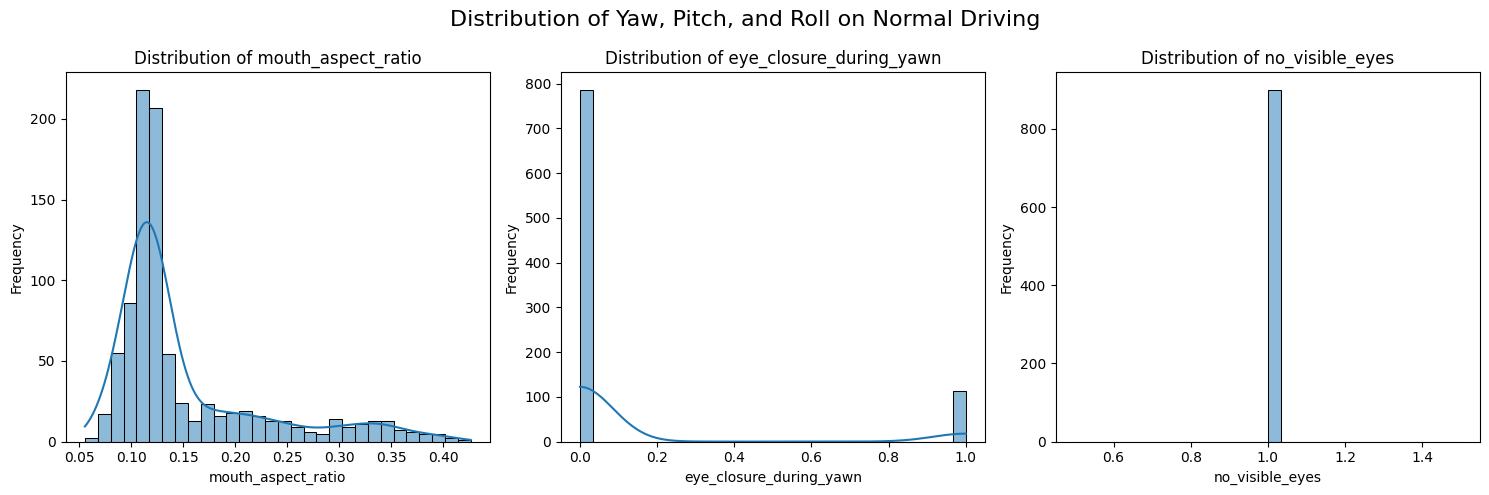

In [65]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the distribution of yaw, pitch, and roll
plt.figure(figsize=(15, 5))

for i, col in enumerate(['mouth_aspect_ratio', 'eye_closure_during_yawn', 'no_visible_eyes'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Yaw, Pitch, and Roll on Normal Driving', fontsize=16)

plt.tight_layout()
plt.show()

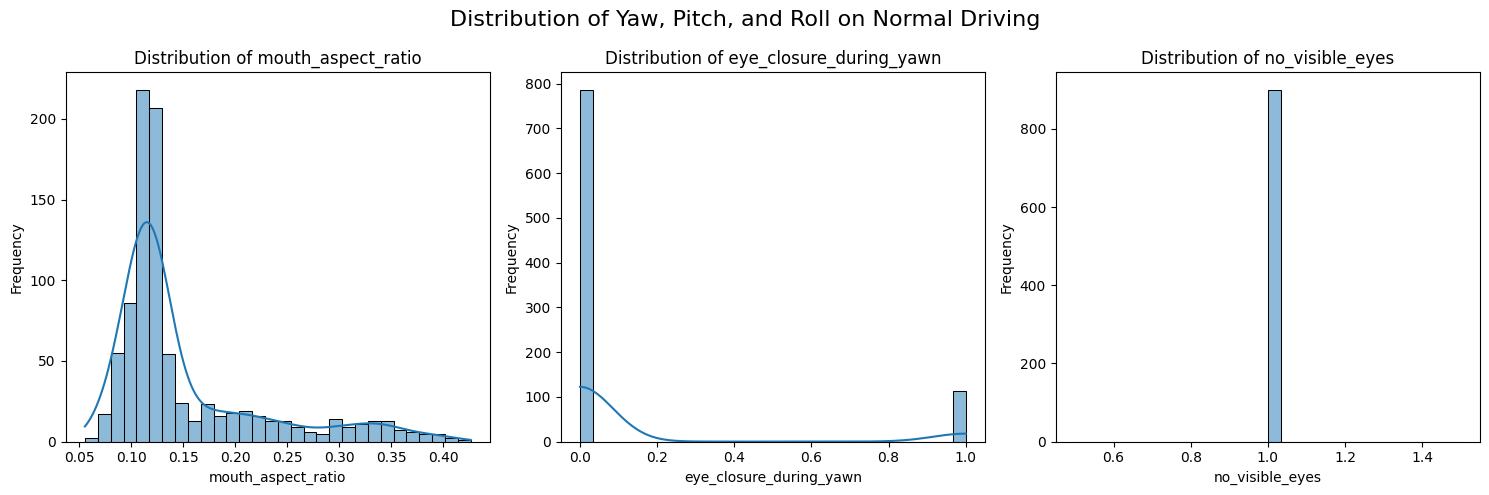

In [55]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the distribution of yaw, pitch, and roll
plt.figure(figsize=(15, 5))

for i, col in enumerate(['mouth_aspect_ratio', 'eye_closure_during_yawn', 'no_visible_eyes'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Yaw, Pitch, and Roll on Normal Driving', fontsize=16)

plt.tight_layout()
plt.show()

In [29]:
df

frame_id  left_eye_aspect_ratio  right_eye_aspect_ratio  \
0           0               0.267366                0.248232   
1           1               0.284681                0.234250   
2           2               0.269600                0.224597   
3           3               0.268587                0.243691   
4           4               0.272733                0.256040   
..        ...                    ...                     ...   
895       895               0.249576                0.202471   
896       896               0.229798                0.219320   
897       897               0.221231                0.244362   
898       898               0.111160                0.154955   
899       899               0.109693                0.178161   

     left_eye_aspect_ratio_3d  right_eye_aspect_ratio_3d  \
0                    0.267366                   0.248232   
1                    0.284681                   0.234250   
2                    0.269600                   0.224597   
3                    0.268587                   0.243691   
4                    0.272733                   0.256040   
..                        ...                        ...   
895                  0.249576                   0.202471   
896                  0.229798                   0.219320   
897                  0.221231                   0.244362   
898                  0.111160                   0.154955   
899                  0.109693                   0.178161   

     left_eye_pupil_distance  right_eye_pupil_distance  no_visible_eyes  \
0                   3.294301                  0.271066             True   
1                   2.335876                  0.455723             True   
2                   2.549099                  0.873973             True   
3                   1.980606                  1.111173             True   
4                   2.006867                  1.041656             True   
..                       ...                       ...              ...   
895                 0.204926                  0.443143             True   
896                 0.282347                  0.376210             True   
897                 0.365055                  0.721766             True   
898                 0.710930                  4.848785             True   
899                 1.051877                  3.932515             True   

     left_eye_closed  right_eye_closed  mouth_aspect_ratio  \
0              False             False            0.123713   
1              False             False            0.124762   
2              False             False            0.112861   
3              False             False            0.098982   
4              False             False            0.093594   
..               ...               ...                 ...   
895            False             False            0.104217   
896            False             False            0.110938   
897            False             False            0.111176   
898             True              True            0.111706   
899             True              True            0.111890   

     eye_closure_during_yawn  left_eye_pupil_movement  \
0                      False                 0.000000   
1                      False                 2.815089   
2                      False                 2.726425   
3                      False                 2.539971   
4                      False                 2.433350   
..                       ...                      ...   
895                    False                 1.025190   
896                    False                 1.015327   
897                    False                 1.010520   
898                    False                 1.012117   
899                    False                 1.023382   

     left_eye_pupil_variance  right_eye_pupil_movement  \
0                   0.000000                  0.000000   
1                   0.229645                  0.363394   
2         

In [ ]:
class head_features():
    def __init__(self, frame_width=640, frame_height=480,
                 baseline_yaw=5, baseline_pitch=-110, baseline_roll=10,
                 yaw_threshold=15, pitch_threshold=20, roll_threshold=20,
                 min_away_duration=10, buffer_size=30, event_window=300):
        """
        Initialize head features tracker with optimized thresholds for interior rear-view mirror camera.
        
        Args:
            frame_width: Width of video frame
            frame_height: Height of video frame
            baseline_yaw: Baseline yaw angle for normal driving (typically 5 degrees right)
            baseline_pitch: Baseline pitch angle for normal driving (typically -110 degrees)
            baseline_roll: Baseline roll angle for normal driving (typically 10 degrees)
            yaw_threshold: Deviation threshold from baseline yaw to detect distraction
            pitch_threshold: Deviation threshold from baseline pitch to detect distraction
            roll_threshold: Deviation threshold from baseline roll to detect distraction
            min_away_duration: Minimum frames to consider as distraction event
            buffer_size: Buffer size for variance calculation
            event_window: Window size for counting distraction events
        """
        self.frame_width = frame_width
        self.frame_height = frame_height
        self.frame_id = 0
        
        # Baseline angles for normal driving position
        self.baseline_yaw = baseline_yaw
        self.baseline_pitch = baseline_pitch
        self.baseline_roll = baseline_roll
        
        # 3D model points for head pose estimation
        self.model_points = np.array([
            (0.0, 0.0, 0.0),              # Nose tip
            (0.0, -330.0, -65.0),         # Chin
            (-225.0, 170.0, -135.0),      # Left eye left corner
            (225.0, 170.0, -135.0),       # Right eye right corner
            (-150.0, -150.0, -125.0),     # Left mouth corner
            (150.0, -150.0, -125.0)       # Right mouth corner
        ])

        # Camera intrinsic parameters
        focal_length = frame_width
        center = (frame_width / 2, frame_height / 2)
        self.camera_matrix = np.array([
            [focal_length, 0, center[0]],
            [0, focal_length, center[1]],
            [0, 0, 1]
        ], dtype="double")

        self.dist_coeffs = np.zeros((4, 1))

        # Buffers for angle tracking
        self.yaw_buffer = deque(maxlen=buffer_size)
        self.pitch_buffer = deque(maxlen=buffer_size)
        self.roll_buffer = deque(maxlen=buffer_size)

        # Thresholds and counters
        self.yaw_threshold = yaw_threshold
        self.pitch_threshold = pitch_threshold
        self.roll_threshold = roll_threshold
        self.current_away_duration = 0
        self.head_away_event_count = 0
        self.min_away_duration = min_away_duration
        self.event_window = event_window
        self.head_away_events_window = deque(maxlen=event_window)
        
        # Additional metrics
        self.distraction_confidence = 0.0
        self.distraction_pattern_detected = False

    def get_landmarks(self, face_landmarks):
        """Extract facial landmarks for head pose estimation."""
        idxs = [1, 199, 130, 359, 61, 291]  # Key facial points
        points = []
        for idx in idxs:
            lm = face_landmarks.landmark[idx]
            points.append((lm.x * self.frame_width, lm.y * self.frame_height))
        return np.array(points, dtype='double')

    def estimate_head_pose(self, face_landmarks):
        """Estimate head pose angles from facial landmarks."""
        if face_landmarks is None:
            return None, None, None

        try:
            image_points = self.get_landmarks(face_landmarks)
            success, rotation_vector, translation_vector = cv2.solvePnP(
                self.model_points, image_points, self.camera_matrix, self.dist_coeffs)

            if not success:
                return None, None, None

            rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
            yaw, pitch, roll = self.rotation_matrix_to_euler_angles(rotation_matrix)

            # Convert to degrees
            yaw, pitch, roll = [angle * 180.0 / np.pi for angle in (yaw, pitch, roll)]

            # Store in buffer for variance calculation
            self.yaw_buffer.append(yaw)
            self.pitch_buffer.append(pitch)
            self.roll_buffer.append(roll)

            return yaw, pitch, roll
            
        except Exception as e:
            print(f"Error in head pose estimation: {e}")
            return None, None, None

    @staticmethod
    def rotation_matrix_to_euler_angles(R):
        """Convert rotation matrix to Euler angles."""
        sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
        singular = sy < 1e-6
        if not singular:
            x = np.arctan2(R[2, 1], R[2, 2])
            y = np.arctan2(-R[2, 0], sy)
            z = np.arctan2(R[1, 0], R[0, 0])
        else:
            x = np.arctan2(-R[1, 2], R[1, 1])
            y = np.arctan2(-R[2, 0], sy)
            z = 0
        return y, x, z  # yaw, pitch, roll

    def calculate_variances(self):
        """Calculate the variance of head pose angles over the buffer window."""
        if len(self.yaw_buffer) < 3:
            return 0.0, 0.0, 0.0
        return np.var(self.yaw_buffer), np.var(self.pitch_buffer), np.var(self.roll_buffer)

    def is_head_away(self, yaw, pitch, roll):
        """
        Determine if head position indicates distraction based on deviation from baseline.
        
        Returns:
            bool: True if head position indicates distraction
            float: Confidence score for distraction (0.0-1.0)
        """
        if yaw is None or pitch is None or roll is None:
            return True, 1.0
        
        # Calculate deviation from baseline normal driving position
        yaw_deviation = abs(yaw - self.baseline_yaw)
        pitch_deviation = abs(pitch - self.baseline_pitch)
        roll_deviation = abs(roll - self.baseline_roll)
        
        # Calculate distraction confidence score (0.0-1.0)
        yaw_factor = min(1.0, yaw_deviation / (self.yaw_threshold * 2))
        pitch_factor = min(1.0, pitch_deviation / (self.pitch_threshold * 2))
        roll_factor = min(1.0, roll_deviation / (self.roll_threshold * 2))
        
        # Combined confidence score (weighted average)
        confidence = 0.5 * yaw_factor + 0.3 * pitch_factor + 0.2 * roll_factor
        
        # Determine if head is away based on thresholds
        is_away = (yaw_deviation > self.yaw_threshold or 
                  pitch_deviation > self.pitch_threshold or 
                  roll_deviation > self.roll_threshold)
        
        return is_away, confidence

    def update_head_away_status(self, frame_id, yaw, pitch, roll):
        """Update head away status and track distraction events."""
        self.frame_id = frame_id
        
        is_away, confidence = self.is_head_away(yaw, pitch, roll)
        self.distraction_confidence = confidence
        
        if is_away:
            self.current_away_duration += 1
        else:
            # Record event if duration threshold met
            if self.current_away_duration >= self.min_away_duration:
                self.head_away_event_count += 1
                self.head_away_events_window.append(frame_id)
            self.current_away_duration = 0

        

        return self.current_away_duration
    
    def count_head_away_events(self, frame_id):
        """Count distraction events within the time window."""
        # Count events within the time window relative to the current frame
        return sum(1 for event_frame in self.head_away_events_window 
                  if frame_id - event_frame <= self.event_window)


    
    def calculate_head_features(self, face_results, frame, frame_id):
        """Calculate all head features and return metrics."""
        yaw, pitch, roll = None, None, None
        nose_point = (self.frame_width // 2, self.frame_height // 2)

        # Extract face landmarks if available
        if hasattr(face_results, 'multi_face_landmarks') and face_results.multi_face_landmarks:
            face_landmarks = face_results.multi_face_landmarks[0]
            nose = face_landmarks.landmark[1]  # Nose tip landmark
            nose_point = (int(nose.x * self.frame_width), int(nose.y * self.frame_height))
            yaw, pitch, roll = self.estimate_head_pose(face_landmarks)

        # Update distraction metrics
        head_away_duration = self.update_head_away_status(frame_id, yaw, pitch, roll)
        yaw_var, pitch_var, roll_var = self.calculate_variances()
        head_away_count = self.count_head_away_events(frame_id)

        # print(f"Frame {frame_id}: Yaw: {yaw}, Pitch: {pitch}, Roll: {roll}, ", 
        #       f"yaw_deviation: {abs(yaw - self.baseline_yaw)}, ",
        #       f"pitch_deviation: {abs(pitch - self.baseline_pitch)}, ",
        #       f"roll_deviation: {abs(roll - self.baseline_roll)}, ",
        #       f"baseline yaw: {self.baseline_yaw}, ",
        #       f"baseline pitch: {self.baseline_pitch}, ",
        #       f"baseline roll: {self.baseline_roll}, ",)

        # Return comprehensive feature dictionary
        return {
            "yaw": yaw,
            "pitch": pitch,
            "roll": roll,
            "yaw_variance": yaw_var,
            "pitch_variance": pitch_var,
            "roll_variance": roll_var,
            "head_away_duration": head_away_duration,
            "head_away_event_count": head_away_count,
            "distraction_confidence": self.distraction_confidence,
            # Add baseline deviations if angles are available
            "yaw_deviation": abs(yaw - self.baseline_yaw) if yaw is not None else None,
            "pitch_deviation": abs(pitch - self.baDistractedseline_pitch) if pitch is not None else None,
            "roll_deviation": abs(roll - self.baseline_roll) if roll is not None else None
        }

In [81]:
def process_video_head(video_path, 
                       baseline_yaw=5, baseline_pitch=-110, baseline_roll=10,
                       yaw_threshold=15, pitch_threshold=20, roll_threshold=20,
                       min_away_duration=10, buffer_size=30, event_window=300):
    df = pd.DataFrame()
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Initialize head_features with all parameters
    head_feature = head_features(
        frame_width=frame_width, 
        frame_height=frame_height,
        baseline_yaw=baseline_yaw, 
        baseline_pitch=baseline_pitch, 
        baseline_roll=baseline_roll,
        yaw_threshold=yaw_threshold, 
        pitch_threshold=pitch_threshold, 
        roll_threshold=roll_threshold,
        min_away_duration=min_away_duration, 
        buffer_size=buffer_size, 
        event_window=event_window
    )
    
    frame_id = 0
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, 
                                  min_detection_confidence=0.5, min_tracking_confidence=0.5)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        face_results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        features = head_feature.calculate_head_features(face_results, frame, frame_id=frame_id)

        df = pd.concat([df, pd.DataFrame([features])], ignore_index=True)
        frame_id += 1
        
    cap.release()
    cv2.destroyAllWindows()
    return df

In [82]:
df = process_video_head(
    video_path="/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/normal_5.mp4",
    baseline_yaw=5,
    baseline_pitch=-110,
    baseline_roll=10,
    yaw_threshold=30,
    pitch_threshold=30,
    roll_threshold=20,
    min_away_duration=15,
    buffer_size=30,
    event_window=300
)
df

I0000 00:00:1746033677.460698  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746033677.506309  272517 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1746033677.508802  272499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746033677.520262  272501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


yaw       pitch      roll  yaw_variance  pitch_variance  \
0    6.829128 -134.332425  9.161373      0.000000        0.000000   
1    6.866425 -132.491130  9.704242      0.000000        0.000000   
2    6.329927 -133.634776  8.963477      0.059825        0.576112   
3    6.818229 -135.012472  9.506208      0.048706        0.868918   
4    6.431092 -134.686884  8.916921      0.051494        0.802504   
..        ...         ...       ...           ...             ...   
895  3.963205 -135.199257  4.917665      0.772824        9.740321   
896  4.281662 -135.161802  4.531771      0.844763       11.037260   
897  4.287513 -134.123154  4.708414      0.931138       12.689304   
898  4.609856 -131.988680  5.473303      1.054037       15.353651   
899  5.582693 -132.061321  5.762042      1.319973       17.811560   

     roll_variance  head_away_duration  head_away_event_count  \
0         0.000000                   0                      0   
1         0.000000                   0                      0   
2         0.098067                   0                      0   
3         0.083456                   0                      0   
4         0.094574                   0                      0   
..             ...                 ...                    ...   
895       0.141538                   0                      1   
896       0.120282                   0                      1   
897       0.093330                   0                      1   
898       0.085194                   0                      1   
899       0.094690                   0                      1   

     distraction_confidence  yaw_deviation  pitch_deviation  roll_deviation  
0                  0.141098       1.829128        24.332425        0.838627  
1                  0.129488       1.866425        22.491130        0.295758  
2                  0.134439       1.329927        23.634776        1.036523  
3                  0.142683       1.818229        25.012472        0.493792  
4                  0.140776       1.431092        24.686884        1.083079  
..                      ...            ...              ...             ...  
895                0.160048       1.036795        25.199257        5.082335  
896                0.159136       0.718338        25.161802        5.468229  
897                0.153011       0.712487        24.123154        5.291586  
898                0.135828       0.390144        21.988680        4.526697  
899                0.136352       0.582693        22.061321        4.237958  

[900 rows x 12 columns]

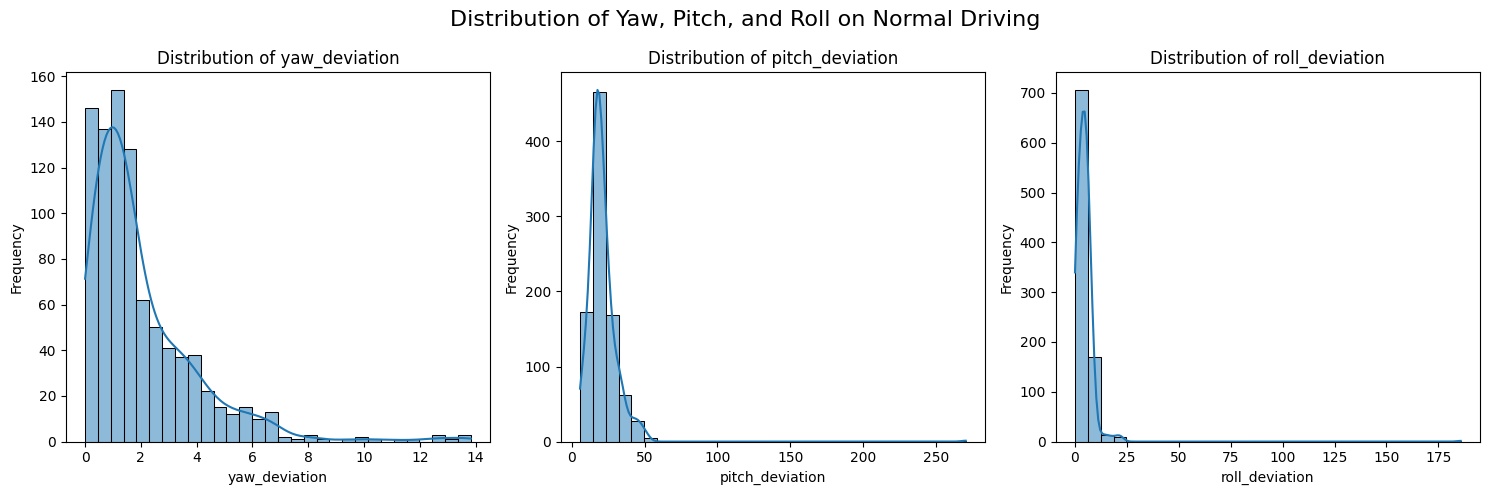

In [83]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the distribution of yaw, pitch, and roll
plt.figure(figsize=(15, 5))

for i, col in enumerate(['yaw_deviation', 'pitch_deviation', 'roll_deviation'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Yaw, Pitch, and Roll on Normal Driving', fontsize=16)

plt.tight_layout()
plt.show()

In [85]:
df = process_video_head("/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/distracted_5.mp4",
                 yaw_threshold=30, pitch_threshold=20, 
                 min_away_duration=15, buffer_size=30, event_window=300)

I0000 00:00:1746033712.934643  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746033712.960701  272631 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1746033712.963026  272604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746033712.974380  272602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/tmp/ipykernel_267018/2012796884.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([features])], ig

In [86]:
df

yaw       pitch        roll  yaw_variance  pitch_variance  \
0     8.800072 -127.314926    9.132113      0.000000        0.000000   
1     7.414522 -127.186367    9.392068      0.000000        0.000000   
2     7.885026 -128.882534    9.704394      0.330937        0.594545   
3     7.803100 -129.225671    9.159385      0.258131        0.829897   
4     8.158750 -129.581203    9.181019      0.211867        0.990566   
..         ...         ...         ...           ...             ...   
895 -31.485541 -140.768764  -31.762384     21.005360     2234.492367   
896 -53.857749  120.788683 -137.677739     38.303534     4317.786771   
897 -52.802358  123.209268 -141.287439     52.902789     6282.424074   
898 -31.147872 -140.427412  -34.180747     52.469050     6274.497760   
899 -54.619368  123.001655 -141.799607     68.474599     8070.419055   

     roll_variance  head_away_duration  head_away_event_count  \
0         0.000000                   0                      0   
1         0.000000                   0                      0   
2         0.054737                   0                      0   
3         0.052784                   0                      0   
4         0.046635                   0                      0   
..             ...                 ...                    ...   
895     384.640035                 170                      1   
896     732.923585                 171                      1   
897    1077.738998                 172                      1   
898    1072.203824                 173                      1   
899    1389.889129                 174                      1   

     distraction_confidence  yaw_deviation  pitch_deviation  roll_deviation  
0                  0.165869       3.800072        17.314926        0.867887  
1                  0.152058       2.414522        17.186367        0.607932  
2                  0.167139       2.885026        18.882534        0.295606  
3                  0.171755       2.803100        19.225671        0.840615  
4                  0.177277       3.158750        19.581203        0.818981  
..                      ...            ...              ...             ...  
895                0.734812      36.485541        30.768764       41.762384  
896                0.990481      58.857749       230.788683      147.677739  
897                0.981686      57.802358       233.209268      151.287439  
898                0.729438      36.147872        30.427412       44.180747  
899                0.996828      59.619368       233.001655      151.799607  

[900 rows x 12 columns]

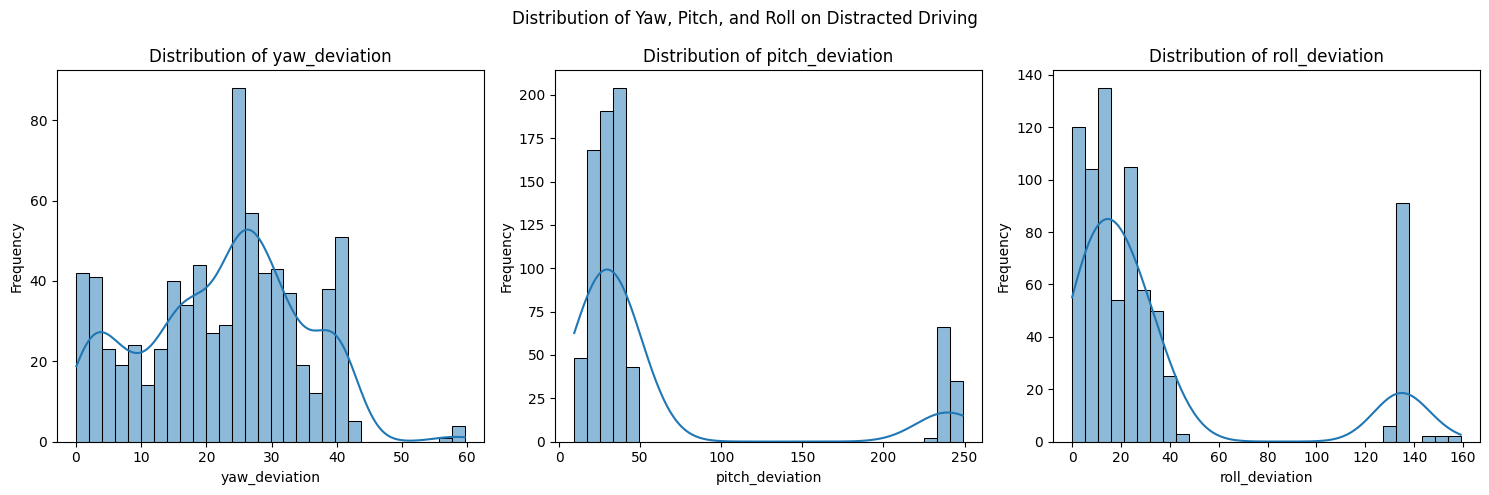

In [87]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the distribution of yaw, pitch, and roll
plt.figure(figsize=(15, 5))

for i, col in enumerate(['yaw_deviation', 'pitch_deviation', 'roll_deviation'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Yaw, Pitch, and Roll on Distracted Driving')
plt.tight_layout()
plt.show()

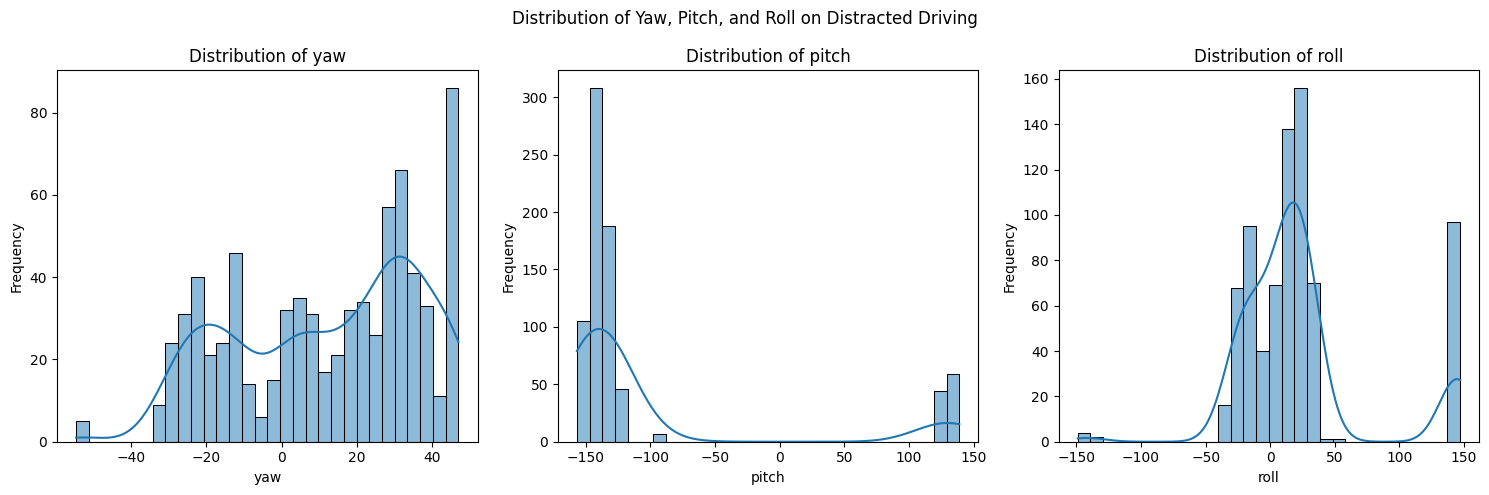

In [90]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the distribution of yaw, pitch, and roll
plt.figure(figsize=(15, 5))

for i, col in enumerate(['yaw', 'pitch', 'roll'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Yaw, Pitch, and Roll on Distracted Driving')
plt.tight_layout()
plt.show()

In [138]:
import mediapipe as mp
import cv2
import os
import numpy as np

hand_mesh = mp.solutions.hands
hands = hand_mesh.Hands(max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)
pose_mesh = mp.solutions.pose
pose = pose_mesh.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

def process_video_pose(pwd, video_file_name):
    # Extract filename from video_path to use in the output filename
    video_path = os.path.join(pwd, video_file_name)
    print(video_path)
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out_path = os.path.join(pwd, "output")
    os.makedirs(out_path, exist_ok=True)
    out = cv2.VideoWriter(os.path.join(out_path, video_file_name), cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame_width, frame_height))
    frame_id = 0

    # Define different alpha and beta values to test
    wheel_box_configs = [
        #{"alpha": 1.2, "beta": 1, "color": (255, 0, 0)},    # Red
        #{"alpha": 1.4, "beta": 1.25, "color": (0, 255, 0)},    # Green
        {"alpha": 1.8, "beta": 1.5, "color": (0, 0, 255)},    # Blue
        #{"alpha": 1.0, "beta": 0.75, "color": (255, 255, 0)},  # Yellow
    ]
    
    # Default wheel box as backup
    default_wheel_box = [0.25, 0.92, 0.4, 0.6]
    default_wheel_box_pixels = [
        int(default_wheel_box[0] * frame_width),  # x_min
        int(default_wheel_box[1] * frame_width),  # x_max
        int(default_wheel_box[2] * frame_height), # y_min
        int(default_wheel_box[3] * frame_height)  # y_max
    ]

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR image to RGB before processing
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        hand_results = hands.process(image_rgb)
        pose_results = pose.process(image_rgb)
        
        # Draw hand landmarks
        if hand_results.multi_hand_landmarks:
            for hand_landmarks in hand_results.multi_hand_landmarks:
                for point in [0, 5, 9, 13, 17]:
                    landmark = hand_landmarks.landmark[point]
                    x, y = int(landmark.x * frame_width), int(landmark.y * frame_height)
                    cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)

        # Draw pose landmarks
        if pose_results.pose_landmarks:
            # Extract key points for wheel box estimation
            landmarks = pose_results.pose_landmarks.landmark
            
            # Draw shoulder and hip landmarks
            key_points = [11, 12, 23, 24, 15, 16, 17, 18, 19, 20]
            for point in key_points:
                landmark = landmarks[point]
                if landmark.visibility > 0.5:
                    x, y = int(landmark.x * frame_width), int(landmark.y * frame_height)
                    cv2.circle(frame, (x, y), 5, (255, 0, 0), -1)
                    
            # Check if we have all the required points for wheel box estimation
            if (landmarks[11].visibility > 0.5 and landmarks[12].visibility > 0.5 and 
                landmarks[23].visibility > 0.5 and landmarks[24].visibility > 0.5):
                
                # Extract coordinates
                x11, y11 = landmarks[11].x * frame_width, landmarks[11].y * frame_height  # Left shoulder
                x12, y12 = landmarks[12].x * frame_width, landmarks[12].y * frame_height  # Right shoulder
                x23, y23 = landmarks[23].x * frame_width, landmarks[23].y * frame_height  # Left hip
                x24, y24 = landmarks[24].x * frame_width, landmarks[24].y * frame_height  # Right hip
                
                # Draw different wheel box estimates
                for config in wheel_box_configs:
                    alpha = config["alpha"]
                    beta = config["beta"]
                    color = config["color"]
                    
                    # Compute wheel box parameters
                    W = alpha * abs(x12 - x11)
                    H = W * 0.6
                    Cx = 0.5 * (x11 + x12)
                    Cy = 0.5 * (y11 + y12) + beta * ((0.5 * (y23 + y24)) - 0.5 * (y11 + y12))
                    
                    xmin, ymin = int(Cx - W/2), int(Cy - 3*H/4)
                    xmax, ymax = int(Cx + W/2), int(Cy + H/4)
                    
                    # Draw this wheel box
                    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
                    
                    # Add parameter text
                    label = f"α={alpha}, β={beta}"
                    cv2.putText(frame, label, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            else:
                # Fall back to default wheel box if pose landmarks not visible
                cv2.rectangle(frame, 
                          (default_wheel_box_pixels[0], default_wheel_box_pixels[2]), 
                          (default_wheel_box_pixels[1], default_wheel_box_pixels[3]), 
                          (0, 0, 255), 2)
                cv2.putText(frame, "Default", (default_wheel_box_pixels[0], default_wheel_box_pixels[2]-5), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        else:
            # Draw default wheel box
            cv2.rectangle(frame, 
                      (default_wheel_box_pixels[0], default_wheel_box_pixels[2]), 
                      (default_wheel_box_pixels[1], default_wheel_box_pixels[3]), 
                      (0, 0, 255), 2)
            cv2.putText(frame, "Default", (default_wheel_box_pixels[0], default_wheel_box_pixels[2]-5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        # Write the processed frame to the output video
        out.write(frame)
        frame_id += 1
        
    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()


I0000 00:00:1746043295.022518  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746043295.064152  297612 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
I0000 00:00:1746043295.068189  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
W0000 00:00:1746043295.079405  297581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746043295.090284  297600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1746043295.130650  297646 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2


W0000 00:00:1746043295.162869  297622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746043295.180794  297633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [139]:
import os

video_dir = "/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data"
pwd = "/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data"

# Get all video files from the directory
video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))]

for video_file in video_files:
    print(f"Processing {video_file}...")
    person = video_file.split("_")[1].split(".")[0]
    # if int(person) > 8:
    #     continue
    video_path = os.path.join(video_dir, video_file)
    try:
        process_video_pose(pwd, video_file)
        print(f"Successfully processed {video_file}")
    except Exception as e:
        print(f"Error processing {video_file}: {e}")

Processing phone_20.mp4...
/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/phone_20.mp4
Successfully processed phone_20.mp4
Processing normal_5.mp4...
/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/normal_5.mp4
Successfully processed normal_5.mp4
Processing blink_10.mp4...
/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/blink_10.mp4
Successfully processed blink_10.mp4
Processing sleep_22.mp4...
/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/sleep_22.mp4
Successfully processed sleep_22.mp4
Processing sleep_2.mp4...
/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/sleep_2.mp4
Successfully processed sleep_2.mp4
Processing normal_25.mp4...
/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/normal_25.mp4
Successfully processed normal_25.mp4
Processing phone_14.mp4...
/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data

KeyboardInterrupt: 

In [ ]:
class hand_features():
    def __init__(self, frame_width=640, frame_height=480, 
                 proximity_threshold=0.2, 
                 alpha=1.8, beta=1.5,  
                 default_wheel_box=[0.25, 0.92, 0.4, 0.6],  
                 window_size=150): 
        self.frame_width = frame_width
        self.frame_height = frame_height
        self.proximity_threshold = proximity_threshold
        self.default_wheel_box = default_wheel_box  # [x_min, x_max, y_min, y_max] normalized
        self.alpha = alpha  # Steering wheel width scaling factor
        self.beta = beta    # Vertical position factor
        
        # Using deques for time-based features
        self.left_hand_near_face_history = deque(maxlen=window_size)
        self.right_hand_near_face_history = deque(maxlen=window_size)
        self.left_hand_off_wheel_history = deque(maxlen=window_size)
        self.right_hand_off_wheel_history = deque(maxlen=window_size)
        
        # Current calculated wheel box
        self.current_wheel_box = default_wheel_box
    
    def calculate_wheel_box(self, pose_landmarks):
        """Calculate dynamic steering wheel box based on body pose landmarks"""
        # Start with default box
        wheel_box = self.default_wheel_box.copy()
        
        # Only calculate if we have valid pose landmarks
        if pose_landmarks and pose_landmarks.pose_landmarks:
            landmarks = pose_landmarks.pose_landmarks.landmark
            
            # Check if we have the required shoulder and hip points
            if (landmarks[11].visibility > 0.5 and landmarks[12].visibility > 0.5 and 
                landmarks[23].visibility > 0.5 and landmarks[24].visibility > 0.5):
                
                # Extract coordinates
                x11, y11 = landmarks[11].x, landmarks[11].y  # Left shoulder
                x12, y12 = landmarks[12].x, landmarks[12].y  # Right shoulder
                x23, y23 = landmarks[23].x, landmarks[23].y  # Left hip
                x24, y24 = landmarks[24].x, landmarks[24].y  # Right hip
                
                # Compute wheel box parameters using alpha and beta
                W = self.alpha * abs(x12 - x11)
                H = W * 0.6
                Cx = 0.5 * (x11 + x12)
                Cy = 0.5 * (y11 + y12) + self.beta * ((0.5 * (y23 + y24)) - 0.5 * (y11 + y12))
                
                # Calculate box in normalized coordinates
                xmin = max(0.0, Cx - W/2)
                xmax = min(1.0, Cx + W/2)
                ymin = max(0.0, Cy - 3*H/4)
                ymax = min(1.0, Cy + H/4)
                
                wheel_box = [xmin, xmax, ymin, ymax]
        
        # Store current wheel box and return it
        self.current_wheel_box = wheel_box
        return wheel_box
    
    def extract_hand_position(self, pose_landmarks):
        # Initialize with default values
        hand_pos = {
            "left_wrist_x": 0, "left_wrist_y": 0, "left_wrist_z": 0,
            "left_palm_x": 0, "left_palm_y": 0, "left_palm_z": 0,
            "right_wrist_x": 0, "right_wrist_y": 0, "right_wrist_z": 0,
            "right_palm_x": 0, "right_palm_y": 0, "right_palm_z": 0
        }
        
        if not pose_landmarks.pose_landmarks:
            return hand_pos
        
        landmarks = pose_landmarks.pose_landmarks.landmark
        
        # Left hand: landmarks 15 (wrist), 17 and 19 (palm)
        if landmarks[15].visibility > 0.5:  # Check if left wrist is visible
            hand_pos["left_wrist_x"] = landmarks[15].x * self.frame_width
            hand_pos["left_wrist_y"] = landmarks[15].y * self.frame_height
            hand_pos["left_wrist_z"] = landmarks[15].z
            
            # Calculate palm center as average of landmarks 17 and 19
            if landmarks[17].visibility > 0.5 and landmarks[19].visibility > 0.5:
                palm_x = (landmarks[17].x + landmarks[19].x) / 2
                palm_y = (landmarks[17].y + landmarks[19].y) / 2
                palm_z = (landmarks[17].z + landmarks[19].z) / 2
                
                hand_pos["left_palm_x"] = palm_x * self.frame_width
                hand_pos["left_palm_y"] = palm_y * self.frame_height
                hand_pos["left_palm_z"] = palm_z
        
        # Right hand: landmarks 16 (wrist), 18 and 20 (palm)
        if landmarks[16].visibility > 0.5:  # Check if right wrist is visible
            hand_pos["right_wrist_x"] = landmarks[16].x * self.frame_width
            hand_pos["right_wrist_y"] = landmarks[16].y * self.frame_height
            hand_pos["right_wrist_z"] = landmarks[16].z
            
            # Calculate palm center as average of landmarks 18 and 20
            if landmarks[18].visibility > 0.5 and landmarks[20].visibility > 0.5:
                palm_x = (landmarks[18].x + landmarks[20].x) / 2
                palm_y = (landmarks[18].y + landmarks[20].y) / 2
                palm_z = (landmarks[18].z + landmarks[20].z) / 2
                
                hand_pos["right_palm_x"] = palm_x * self.frame_width
                hand_pos["right_palm_y"] = palm_y * self.frame_height
                hand_pos["right_palm_z"] = palm_z
                
        return hand_pos

    def compute_hand_eye_depth(self, pose_landmarks, face_landmarks):
        depths = {"left_hand_eye_depth": 0.0, "right_hand_eye_depth": 0.0}
        
        if not pose_landmarks.pose_landmarks or not face_landmarks.multi_face_landmarks:
            return depths
        
        # Calculate eye center correctly
        eye_center = [0, 0, 0]  # Default initialization
        if face_landmarks.multi_face_landmarks:
            left_eye = face_landmarks.multi_face_landmarks[0].landmark[468]
            right_eye = face_landmarks.multi_face_landmarks[0].landmark[473]
            eye_center = [
                (left_eye.x + right_eye.x) / 2 * self.frame_width,
                (left_eye.y + right_eye.y) / 2 * self.frame_height,
                (left_eye.z + right_eye.z) / 2
            ]
        
        landmarks = pose_landmarks.pose_landmarks.landmark
        
        # Calculate depth for left hand (wrist)
        if landmarks[15].visibility > 0.5:  # Left wrist
            left_wrist_3d = [
                landmarks[15].x * self.frame_width,
                landmarks[15].y * self.frame_height,
                landmarks[15].z
            ]
            depths["left_hand_eye_depth"] = np.sqrt(sum((a - b) ** 2 for a, b in zip(left_wrist_3d, eye_center)))
        
        # Calculate depth for right hand (wrist)
        if landmarks[16].visibility > 0.5:  # Right wrist
            right_wrist_3d = [
                landmarks[16].x * self.frame_width,
                landmarks[16].y * self.frame_height,
                landmarks[16].z
            ]
            depths["right_hand_eye_depth"] = np.sqrt(sum((a - b) ** 2 for a, b in zip(right_wrist_3d, eye_center)))
            
        return depths

    def calculate_angle_3d(self, point1, point2, point3):
        """Calculate the angle between three 3D points, with point2 as the vertex"""
        # Create vectors
        vector1 = [point1[0] - point2[0], point1[1] - point2[1], point1[2] - point2[2]]
        vector2 = [point3[0] - point2[0], point3[1] - point2[1], point3[2] - point2[2]]
        
        # Calculate dot product
        dot_product = sum(a * b for a, b in zip(vector1, vector2))
        
        # Calculate magnitudes
        mag1 = np.sqrt(sum(a ** 2 for a in vector1))
        mag2 = np.sqrt(sum(a ** 2 for a in vector2))
        
        # Calculate angle
        if mag1 * mag2 == 0:
            return 0.0
        
        cos_angle = dot_product / (mag1 * mag2)
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0)) * 180 / np.pi
        return angle

    def extract_arm_angles(self, pose_landmarks):
        """Extract left and right elbow angles (shoulder-elbow-wrist)"""
        angles = {"left_elbow_angle": 0.0, "right_elbow_angle": 0.0}
        
        if not pose_landmarks.pose_landmarks:
            return angles
        
        landmarks = pose_landmarks.pose_landmarks.landmark
        
        # Extract 3D points for right arm (shoulder 12, elbow 14, wrist 16)
        if landmarks[12].visibility > 0.5 and landmarks[14].visibility > 0.5 and landmarks[16].visibility > 0.5:
            right_shoulder = [
                landmarks[12].x * self.frame_width,
                landmarks[12].y * self.frame_height,
                landmarks[12].z
            ]
            right_elbow = [
                landmarks[14].x * self.frame_width,
                landmarks[14].y * self.frame_height,
                landmarks[14].z
            ]
            right_wrist = [
                landmarks[16].x * self.frame_width,
                landmarks[16].y * self.frame_height,
                landmarks[16].z
            ]
            angles["right_elbow_angle"] = self.calculate_angle_3d(right_shoulder, right_elbow, right_wrist)
        
        # Extract 3D points for left arm (shoulder 11, elbow 13, wrist 15)
        if landmarks[11].visibility > 0.5 and landmarks[13].visibility > 0.5 and landmarks[15].visibility > 0.5:
            left_shoulder = [
                landmarks[11].x * self.frame_width,
                landmarks[11].y * self.frame_height,
                landmarks[11].z
            ]
            left_elbow = [
                landmarks[13].x * self.frame_width,
                landmarks[13].y * self.frame_height,
                landmarks[13].z
            ]
            left_wrist = [
                landmarks[15].x * self.frame_width,
                landmarks[15].y * self.frame_height,
                landmarks[15].z
            ]
            angles["left_elbow_angle"] = self.calculate_angle_3d(left_shoulder, left_elbow, left_wrist)
        
        return angles

    def check_hand_off_steering_wheel(self, pose_landmarks):
        # Calculate the current wheel box
        current_wheel_box = self.calculate_wheel_box(pose_landmarks)
        
        # Default return with current window statistics
        result = {
            "left_hand_off_wheel": False,
            "left_hand_off_wheel_duration": sum(self.left_hand_off_wheel_history),
            "right_hand_off_wheel": False, 
            "right_hand_off_wheel_duration": sum(self.right_hand_off_wheel_history)
        }
        
        # If no pose detected, assume both hands are off wheel
        if not pose_landmarks.pose_landmarks:
            self.left_hand_off_wheel_history.append(1)
            self.right_hand_off_wheel_history.append(1)
            result["left_hand_off_wheel"] = True
            result["right_hand_off_wheel"] = True
            return result
        
        # Convert normalized wheel box to pixel coordinates
        wheel_box_pixels = [
            current_wheel_box[0] * self.frame_width,  # x_min
            current_wheel_box[1] * self.frame_width,  # x_max
            current_wheel_box[2] * self.frame_height, # y_min
            current_wheel_box[3] * self.frame_height  # y_max
        ]
        
        landmarks = pose_landmarks.pose_landmarks.landmark
        
        # Check left wrist (landmark 15)
        if landmarks[15].visibility > 0.5:
            x, y = landmarks[15].x * self.frame_width, landmarks[15].y * self.frame_height
            
            # Check if hand is within the steering wheel area
            in_wheel = (wheel_box_pixels[0] <= x <= wheel_box_pixels[1] and 
                        wheel_box_pixels[2] <= y <= wheel_box_pixels[3])
            
            if not in_wheel:
                result["left_hand_off_wheel"] = True
                self.left_hand_off_wheel_history.append(1)
            else:
                self.left_hand_off_wheel_history.append(0)
        else:
            # Left hand not detected
            self.left_hand_off_wheel_history.append(1)
            result["left_hand_off_wheel"] = True
            
        # Check right wrist (landmark 16)
        if landmarks[16].visibility > 0.5:
            x, y = landmarks[16].x * self.frame_width, landmarks[16].y * self.frame_height
            
            # Check if hand is within the steering wheel area
            in_wheel = (wheel_box_pixels[0] <= x <= wheel_box_pixels[1] and 
                        wheel_box_pixels[2] <= y <= wheel_box_pixels[3])
            30
            if not in_wheel:
                result["right_hand_off_wheel"] = True
                self.right_hand_off_wheel_history.append(1)
            else:
                self.right_hand_off_wheel_history.append(0)
        else:
            # Right hand not detected
            self.right_hand_off_wheel_history.append(1)
            result["right_hand_off_wheel"] = True
            
        # Update duration values with the latest sums
        result["left_hand_off_wheel_duration"] = sum(self.left_hand_off_wheel_history)
        result["right_hand_off_wheel_duration"] = sum(self.right_hand_off_wheel_history)
        
        return result
    
    def check_hand_proximity_to_face(self, pose_landmarks, face_landmarks):
            # Initialize result dictionary
            result = {
                "left_hand_distance": 0,
                "right_hand_distance": 0
            }
            
            # If no face or pose are detected, return default values
            if not pose_landmarks.pose_landmarks or not face_landmarks.multi_face_landmarks:
                # No distance can be calculated when face is not detected
                self.left_hand_near_face_history.append(0)
                self.right_hand_near_face_history.append(0)
                return result
            
            # Get nose position as reference point for face
            nose = face_landmarks.multi_face_landmarks[0].landmark[1]  # Nose tip landmark
            nose_pos = [nose.x * self.frame_width, nose.y * self.frame_height]
            
            landmarks = pose_landmarks.pose_landmarks.landmark
            
            # Check left wrist (landmark 15)
            if landmarks[15].visibility > 0.5:
                wrist_pos = [landmarks[15].x * self.frame_width, landmarks[15].y * self.frame_height]
                
                # Calculate Euclidean distance between wrist and nose
                distance = np.sqrt((wrist_pos[0] - nose_pos[0])**2 + (wrist_pos[1] - nose_pos[1])**2)
                result["left_hand_distance"] = distance
                
                # Update history - we're now tracking if hand is detected, not proximity
                self.left_hand_near_face_history.append(distance)
            else:
                # Left hand not detected30
                self.left_hand_near_face_history.append(0)
                
            # Check right wrist (landmark 16)
            if landmarks[16].visibility > 0.5:
                wrist_pos = [landmarks[16].x * self.frame_width, landmarks[16].y * self.frame_height]
                
                # Calculate Euclidean distance between wrist and nose
                distance = np.sqrt((wrist_pos[0] - nose_pos[0])**2 + (wrist_pos[1] - nose_pos[1])**2)
                result["right_hand_distance"] = distance
                
                # Update history - we're now tracking if hand is detected, not proximity
                self.right_hand_near_face_history.append(distance)
            else:
                # Right hand not detected
                self.right_hand_near_face_history.append(0)
            
            # Include hand detection durations for compatibility
            # Calculate variance of hand distances from history
            left_distances = [d for d in self.left_hand_near_face_history if d > 0]
            right_distances = [d for d in self.right_hand_near_face_history if d > 0]
            
            result["left_hand_distance_var"] = np.var(left_distances) if len(left_distances) > 1 else 0.0
            result["right_hand_distance_var"] = np.var(right_distances) if len(right_distances) > 1 else 0.0
            
            return result

    def calculate_hand_features(self, pose_results, face_landmarks, frame_id):
        # Calculate current wheel box 
        current_wheel_box = self.calculate_wheel_box(pose_results)
        
        # Extract all features
        hand_pos = self.extract_hand_position(pose_results)
        hand_eye_depth = self.compute_hand_eye_depth(pose_results, face_landmarks)
        arm_angles = self.extract_arm_angles(pose_results)
        hand_off_wheel = self.check_hand_off_steering_wheel(pose_results)
        hand_proximity = self.check_hand_proximity_to_face(pose_results, face_landmarks)
        
        # Include wheel box information in the output
        wheel_box_info = {
            "wheel_box_x_min": current_wheel_box[0],
            "wheel_box_x_max": current_wheel_box[1],
            "wheel_box_y_min": current_wheel_box[2],
            "wheel_box_y_max": current_wheel_box[3]
        }
        
        # Combine all features into a single dictionary
        data = {
            **hand_pos,
            **hand_eye_depth,
            **arm_angles,
            **hand_off_wheel,
            **hand_proximity
        }
        
        return data


In [172]:
def process_video_hand(video_path, proximity_threshold=0.2, 
                       alpha=1.8, beta=1.5, 
                       default_wheel_box=[0.25, 0.92, 0.4, 0.6], 
                       window_size=150):
    df = pd.DataFrame()
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Initialize hand_features with all parameters
    hand_feature = hand_features(
        frame_width=frame_width, 
        frame_height=frame_height,
        proximity_threshold=proximity_threshold,
        alpha=alpha,
        beta=beta,
        default_wheel_box=default_wheel_box,
        window_size=window_size
    )
    
    frame_id = 0
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, 
                                  min_detection_confidence=0.5, min_tracking_confidence=0.5)
    
    mp_pose = mp.solutions.pose
    pose_mesh = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Process the frame for face and pose landmarks
        face_results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        pose_results = pose_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        # Calculate hand features
        features = hand_feature.calculate_hand_features(pose_results, face_results, frame_id)
        
        # Append to DataFrame
        df = pd.concat([df, pd.DataFrame([features])], ignore_index=True)
        
        frame_id += 1
        
    cap.release()
    cv2.destroyAllWindows()
    
    return df

In [173]:
df = process_video_hand(
    video_path="/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/normal_5.mp4",
    proximity_threshold=0.2,
    alpha=1.8,
    beta=1.5,
    default_wheel_box=[0.25, 0.92, 0.4, 0.6],
    window_size=150
)

df

I0000 00:00:1746047621.930233  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746047621.958281  301240 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1746047621.960311  301214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1746047621.961830  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
W0000 00:00:1746047621.970195  301213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1746047621.978652  301274 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1746047622.010108  301244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inf

left_wrist_x  left_wrist_y  left_wrist_z  left_palm_x  left_palm_y  \
0      471.898305    476.991978     -1.000774   491.678057   492.633762   
1      476.198874    477.232790     -1.057108   498.551148   494.287348   
2      477.285715    476.634407     -1.053832   499.562545   493.978014   
3      477.493962    475.548878     -1.078516   499.072570   489.911299   
4      477.987639    475.505362     -0.933507   498.437594   489.190063   
..            ...           ...           ...          ...          ...   
895    470.680432    432.117205     -0.780449   479.614699   456.801510   
896    470.940789    437.586851     -0.799303   482.108670   460.379162   
897    470.845131    439.834986     -0.787577   483.194820   462.995496   
898    471.147780    439.532290     -0.782936   485.492921   463.734183   
899    472.008222    441.054268     -0.782469   489.435655   466.181388   

     left_palm_z  right_wrist_x  right_wrist_y  right_wrist_z  right_palm_x  \
0      -1.142441     163.330275     455.798836      -1.015654    147.444109   
1      -1.218347     163.109443     455.530958      -1.123180    147.353045   
2      -1.208465     162.467145     456.265011      -1.091079    146.773599   
3      -1.247332     163.187093     458.752413      -1.126277    147.934615   
4      -1.090819     163.213663     458.426828      -1.011732    147.273520   
..           ...            ...            ...            ...           ...   
895    -0.921248     174.238443     456.835012      -0.658997    156.586300   
896    -0.941454     168.630958     455.819979      -0.729879    149.817381   
897    -0.917475     169.372889     451.841125      -0.701663    148.276315   
898    -0.919567     172.047524     449.717989      -0.744257    152.618967   
899    -0.913355     170.357587     449.925356      -0.721839    151.889363   

     ...  left_elbow_angle  right_elbow_angle  left_hand_off_wheel  \
0    ...        156.846457         159.314594                False   
1    ...        153.872293         157.485144                 True   
2    ...        153.219442         156.828208                 True   
3    ...        152.126874         153.559943                 True   
4    ...        151.823459         151.592147                 True   
..   ...               ...                ...                  ...   
895  ...        166.007698         154.692986                False   
896  ...        165.785101         149.457362                False   
897  ...        164.735255         149.710334                False   
898  ...        163.785692         150.299866                False   
899  ...        163.588991         149.972515                False   

     left_hand_off_wheel_duration  right_hand_off_wheel  \
0                               0                 False   
1                               1                 False   
2                               2                 False   
3                               3                 False   
4                               4                 False   
..                            ...                   ...   
895                             6                 False   
896                             6                 False   
897                             6                 False   
898                             6                 False   
899                             6                 False   

     right_hand_off_wheel_duration  left_hand_distance  right_hand_distance  \
0                                0          390.744036           349.840995   
1                                0          392.715965           348.788099   
2                                0          392.728697           350.501097   
3                                0          392.195706           352.890377   
4                                0          392.222307           352.728323   
..                             ...                 ...                  ...   
895                              0          346.9099

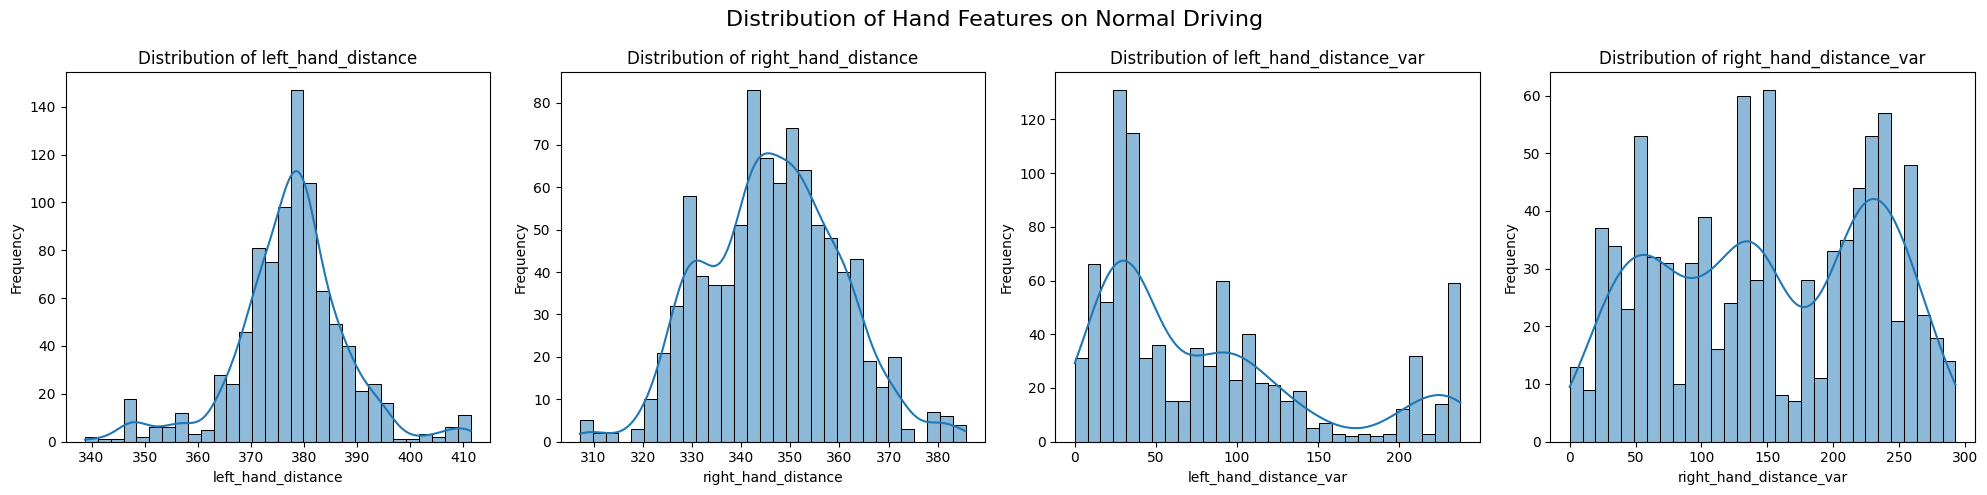

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the distribution of hand features
plt.figure(figsize=(20, 5))
for i, col in enumerate(['left_hand_distance', 'right_hand_distance', 
                         'left_hand_distance_var', 'right_hand_distance_var'], 1):
    plt.subplot(1, 4, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Hand Features on Normal Driving', fontsize=16)
plt.tight_layout()
plt.show()

In [175]:
df = process_video_hand(
    video_path="/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/phone_5.mp4",
    proximity_threshold=0.2,
    alpha=1.8,
    beta=1.5,
    default_wheel_box=[0.25, 0.92, 0.4, 0.6],
    window_size=150
)

df

I0000 00:00:1746047669.618610  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746047669.657506  301347 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1746047669.660089  301315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1746047669.660785  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
W0000 00:00:1746047669.668121  301317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1746047669.694304  301381 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1746047669.727626  301360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inf

left_wrist_x  left_wrist_y  left_wrist_z  left_palm_x  left_palm_y  \
0      471.579530    452.942219     -1.363833   483.693051   481.154437   
1      472.516351    453.860836     -1.146150   485.299641   480.953379   
2      473.340003    454.119215     -0.560193   487.975820   481.852398   
3      473.767247    453.867731     -0.687015   488.372294   481.850367   
4      473.629650    450.822916     -0.667682   487.985235   481.316085   
..            ...           ...           ...          ...          ...   
895    459.851604    475.630846     -0.643883   477.145672   505.446310   
896    458.568295    475.442505     -0.628384   476.286775   504.562025   
897    455.713545    475.615368     -0.605904   473.874557   504.583282   
898    455.742416    478.279295     -0.603522   472.771670   508.008614   
899    456.057233    485.466042     -0.578753   472.517622   515.644741   

     left_palm_z  right_wrist_x  right_wrist_y  right_wrist_z  right_palm_x  \
0      -1.499674     246.950920     352.103405      -1.650962    265.976445   
1      -1.264600     247.674971     352.098370      -1.583638    268.106106   
2      -0.636043     248.801644     352.626400      -1.138312    268.128540   
3      -0.781945     248.079427     349.116068      -1.219434    264.100784   
4      -0.759221     248.071557     348.997736      -1.198602    263.574004   
..           ...            ...            ...            ...           ...   
895    -0.730854     249.887520     355.866137      -1.007523    264.242679   
896    -0.716939     249.539117     355.721884      -0.995539    264.229305   
897    -0.681816     249.508524     354.591351      -0.986590    264.287764   
898    -0.680265     249.210187     354.640245      -0.985946    264.223737   
899    -0.648993     249.200740     354.251976      -0.962366    264.223133   

     ...  left_elbow_angle  right_elbow_angle  left_hand_off_wheel  \
0    ...        178.414463          23.905114                 True   
1    ...        179.487777          23.394480                 True   
2    ...        176.564732          23.696630                 True   
3    ...        175.024043          22.168104                 True   
4    ...        173.937915          22.442135                 True   
..   ...               ...                ...                  ...   
895  ...        168.920984          27.827113                False   
896  ...        168.560937          27.519543                False   
897  ...        168.421582          27.005158                False   
898  ...        168.490719          26.809307                False   
899  ...        169.210895          26.548891                False   

     left_hand_off_wheel_duration  right_hand_off_wheel  \
0                               1                 False   
1                               2                 False   
2                               3                 False   
3                               4                 False   
4                               5                 False   
..                            ...                   ...   
895                            97                 False   
896                            96                 False   
897                            95                 False   
898                            94                 False   
899                            93                 False   

     right_hand_off_wheel_duration  left_hand_distance  right_hand_distance  \
0                                0            0.000000             0.000000   
1                                0            0.000000             0.000000   
2                                0            0.000000             0.000000   
3                                0            0.000000             0.000000   
4                                0            0.000000             0.000000   
..                             ...                 ...                  ...   
895                              0          319.8157

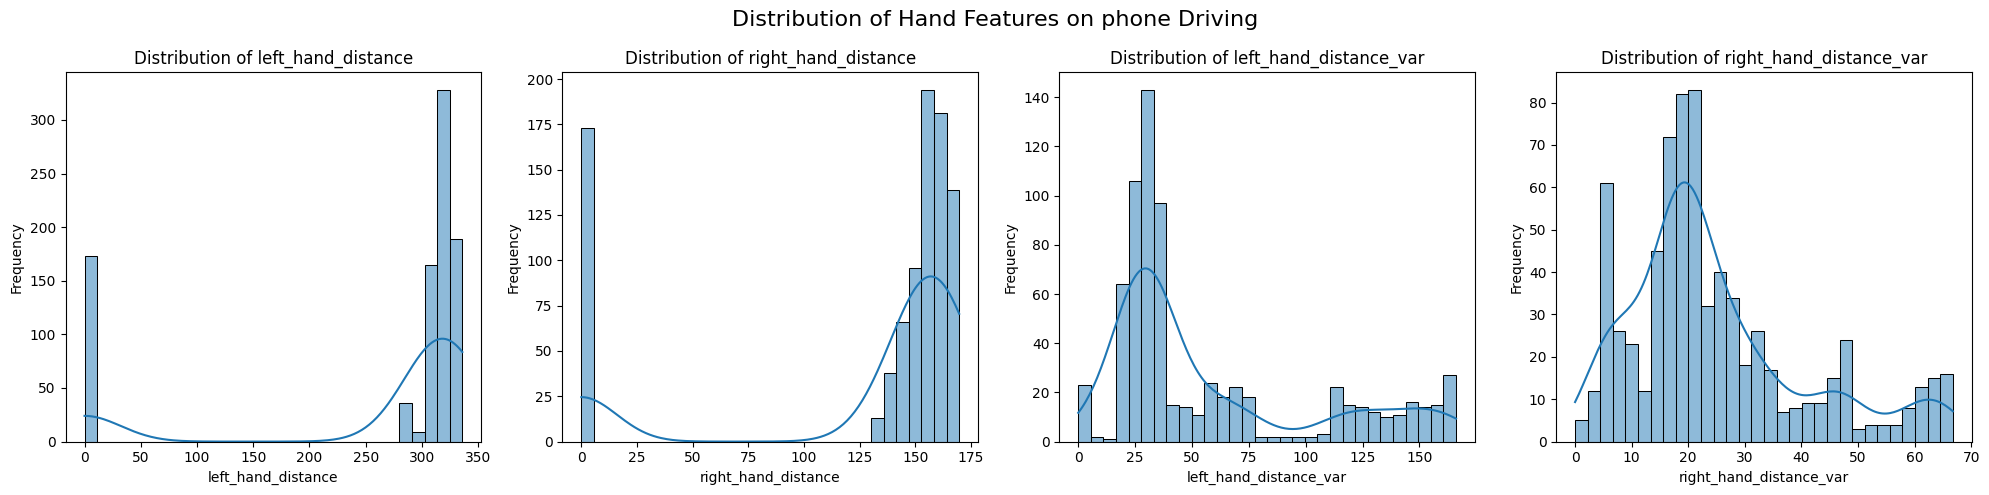

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the distribution of hand features
plt.figure(figsize=(20, 5))
for i, col in enumerate(['left_hand_distance', 'right_hand_distance', 
                         'left_hand_distance_var', 'right_hand_distance_var'], 1):
    plt.subplot(1, 4, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Hand Features on phone Driving', fontsize=16)
plt.tight_layout()
plt.show()

In [177]:
df = process_video_hand(
    video_path="/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/distracted_5.mp4",
    proximity_threshold=0.2,
    alpha=1.8,
    beta=1.5,
    default_wheel_box=[0.25, 0.92, 0.4, 0.6],
    window_size=150
)

df

I0000 00:00:1746047697.631896  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746047697.674344  301485 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1746047697.676904  301456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1746047697.677823  267018 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
W0000 00:00:1746047697.683832  301453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1746047697.724250  301519 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1746047697.754909  301490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inf

left_wrist_x  left_wrist_y  left_wrist_z  left_palm_x  left_palm_y  \
0      462.424786    460.415697     -0.827116   484.542984   476.460528   
1      463.143414    460.964813     -0.878728   485.266666   479.549561   
2      463.846625    461.135187     -0.945031   485.674598   480.645504   
3      463.850616    460.952196     -0.932449   485.598364   480.993447   
4      463.370941    460.525246     -0.874110   485.207539   481.030583   
..            ...           ...           ...          ...          ...   
895    471.508301    475.823364     -0.586974   488.693724   500.778265   
896    471.782917    476.484489     -0.557577   489.016941   502.484064   
897    472.124802    477.389860     -0.512884   489.618233   503.345575   
898    472.447697    477.972651     -0.517022   490.310839   504.001780   
899    472.582172    478.255291     -0.485114   490.545913   504.264278   

     left_palm_z  right_wrist_x  right_wrist_y  right_wrist_z  right_palm_x  \
0      -0.978238     166.075366     473.238201      -0.845920    147.252164   
1      -1.026771     173.132032     471.794643      -0.980458    156.910603   
2      -1.097571     172.678573     471.702232      -0.962019    154.952360   
3      -1.057645     172.430238     471.543589      -0.893811    154.171338   
4      -1.007357     172.106329     471.548510      -0.837776    152.935256   
..           ...            ...            ...            ...           ...   
895    -0.704156     154.732051     468.297443      -0.889282    138.256888   
896    -0.678152     153.785511     468.344622      -0.873575    138.016552   
897    -0.630025     153.461135     466.029396      -0.793414    138.159142   
898    -0.634807     153.111895     463.999929      -0.784560    138.486982   
899    -0.599355     153.053702     463.226280      -0.730221    138.421474   

     ...  left_elbow_angle  right_elbow_angle  left_hand_off_wheel  \
0    ...        162.051713         146.883058                False   
1    ...        161.739548         147.475252                False   
2    ...        161.255845         147.063997                False   
3    ...        162.871203         147.635983                False   
4    ...        164.771462         146.573778                False   
..   ...               ...                ...                  ...   
895  ...        153.291911         146.311201                False   
896  ...        153.186548         146.733118                False   
897  ...        153.212862         146.181055                False   
898  ...        153.212950         145.927867                False   
899  ...        153.210275         146.677993                False   

     left_hand_off_wheel_duration  right_hand_off_wheel  \
0                               0                 False   
1                               0                 False   
2                               0                 False   
3                               0                 False   
4                               0                 False   
..                            ...                   ...   
895                             0                 False   
896                             0                 False   
897                             0                 False   
898                             0                 False   
899                             0                 False   

     right_hand_off_wheel_duration  left_hand_distance  right_hand_distance  \
0                                0          350.763002           337.266084   
1                                0          352.651456           333.526262   
2                                0          353.923488           334.250555   
3                                0          353.494432           334.307839   
4                                0          352.694025           334.192813   
..                             ...                 ...                  ...   
895                              0          332.7635

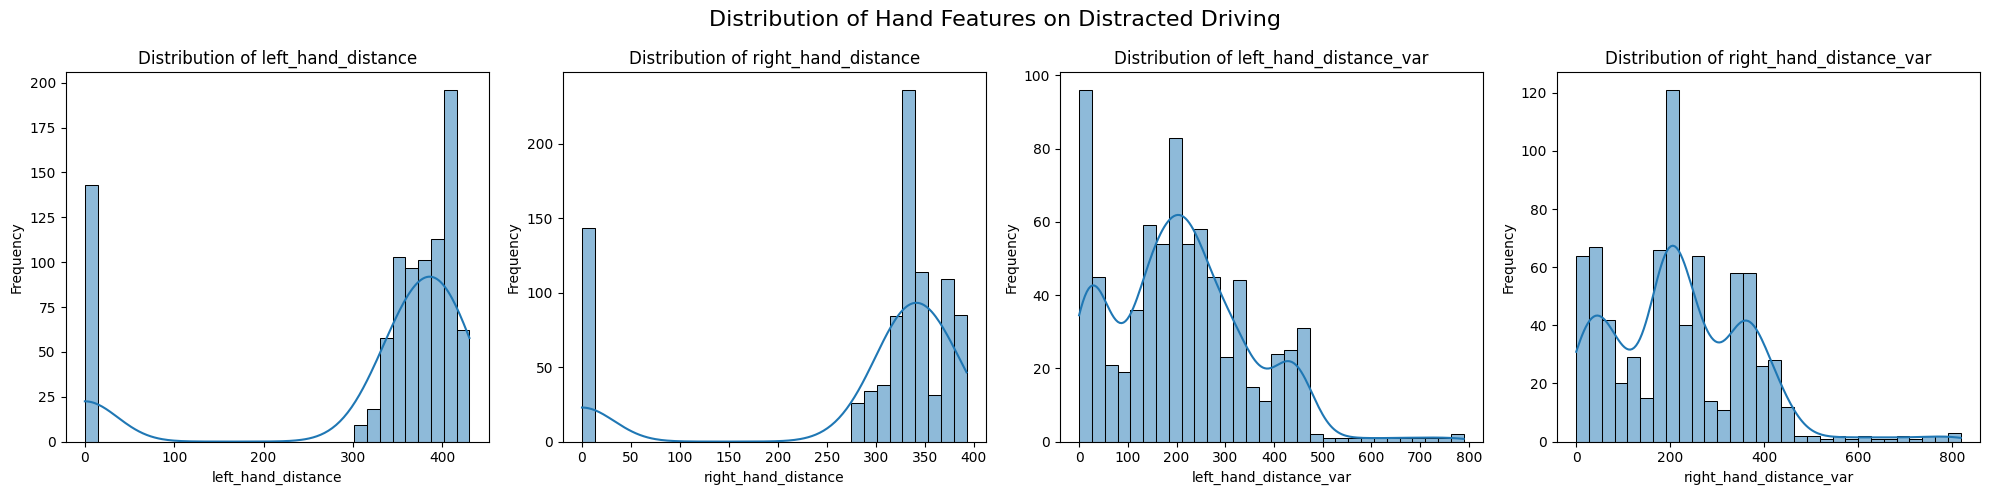

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the distribution of hand features
plt.figure(figsize=(20, 5))
for i, col in enumerate(['left_hand_distance', 'right_hand_distance', 
                         'left_hand_distance_var', 'right_hand_distance_var'], 1):
    plt.subplot(1, 4, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Hand Features on Distracted Driving', fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
df1 = pd.read_csv("/home/harsh/Downloads/sem2/edgeai/edge ai project/output_final.csv")
df2 = pd.read_csv("/home/harsh/Downloads/sem2/edgeai/edge ai project/output_final_2.csv")


import seaborn as sns
import matplotlib.pyplot as plt
# Plot the distribution of all 56 features
plt.figure(figsize=(80, 80))
for i, col in enumerate(df1.columns, 1):
    plt.subplot(8, 8, i)
    sns.histplot(df1[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of All Features on Normal Driving', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the distribution of all 56 features
plt.figure(figsize=(80, 80))
for i, col in enumerate(df2.columns, 1):
    plt.subplot(8, 8, i)
    sns.histplot(df2[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of All Features on Distracted Driving', fontsize=16)
plt.tight_layout()
plt.show()

# model training

In [2]:
import pandas as pd
import numpy as np

In [68]:
df = pd.read_csv("/home/harsh/Downloads/sem2/edgeai/edge ai project/output_final_2.csv")

In [4]:
kachra_columns = [3,4,5,6,7,8,9,10,13,47,48,50,51,59,60]
for i in kachra_columns:
    print(df.columns[i])
    print(df.iloc[:, i].unique())

left_eye_aspect_ratio_3d
['0.0' '0.20940552738555523' '0.30010496736234166' ... 0.157873586191815
 0.1680163541081913 0.1470774710113569]
right_eye_aspect_ratio_3d
['0.0' '0.28770289741704297' '0.31242006309171333' ... 0.2501151262028389
 0.2309029011061282 0.23109677990216]
left_eye_pupil_distance
['0.0' '4.201549025451126' '1.7686348855401994' ... 1.6117989219043052
 1.6422421520191888 0.7952583600930494]
right_eye_pupil_distance
['0.0' '2.544288747393554' '0.8045122430375081' ... 2.476271986110389
 2.326571676109765 1.111449420038009]
no_visible_eyes
['True' nan '0.4354621280121762' True]
left_eye_closed
['True' 'False' nan '0.15584796261015813' True False]
right_eye_closed
['True' 'False' nan '0.04554137888905478' True False]
mouth_aspect_ratio
['0.0' '0.331501801513626' '0.4906242262181843' ... 0.2136878130098385
 0.198885936367592 0.1843401378841845]
eye_closure_during_yawn
['False' nan '0.5334092366921431' 'True' True False]
right_hand_eye_depth
['0.0' '383.97508353969346' '398.

In [69]:
columns = df.columns
# check which are 56, 57 columns and data types present in them
columns[56], columns[57], df[columns[56]].dtype, df[columns[57]].dtype

('left_hand_distance_var',
 'right_hand_distance_var',
 dtype('float64'),
 dtype('float64'))

In [70]:
df['phone_presence'].unique()

KeyError: 'phone_presence'

In [71]:

df['phone_duration'].unique()

KeyError: 'phone_duration'

In [72]:

df['phone_duration'].apply(type).value_counts()



KeyError: 'phone_duration'

In [73]:
df.head()

frame_id  left_eye_aspect_ratio  right_eye_aspect_ratio  \
0       149               0.293122                0.284902   
1       150               0.292932                0.285266   
2       151               0.283269                0.284052   
3       152               0.291061                0.281447   
4       153               0.280562                0.284869   

   left_eye_aspect_ratio_3d  right_eye_aspect_ratio_3d  \
0                  0.293122                   0.284902   
1                  0.292932                   0.285266   
2                  0.283269                   0.284052   
3                  0.291061                   0.281447   
4                  0.280563                   0.284869   

   left_eye_pupil_distance  right_eye_pupil_distance  no_visible_eyes  \
0                 0.674278                  1.242143             True   
1                 0.682913                  1.181420             True   
2                 0.603325                  1.014694             True   
3                 0.645493                  1.014462             True   
4                 0.649153                  1.178608             True   

   left_eye_closed  right_eye_closed  ...  left_hand_distance  \
0            False             False  ...          117.717484   
1            False             False  ...          118.069691   
2            False             False  ...          117.946825   
3            False             False  ...          118.446784   
4            False             False  ...          118.125242   

   right_hand_distance  left_hand_distance_var  right_hand_distance_var  \
0           344.431240                1.399558                47.815804   
1           345.315985                1.480769                50.548666   
2           344.559786                1.555679                55.350023   
3           343.760300                1.555019                60.247584   
4           338.200135                1.538283                73.131720   

   wheel_box_x_min  wheel_box_x_max  wheel_box_y_min  wheel_box_y_max  \
0         0.093228         0.707928         0.701055              1.0   
1         0.092885         0.709264         0.701104              1.0   
2         0.092670         0.710045         0.701346              1.0   
3         0.092635         0.710065         0.701942              1.0   
4         0.092536         0.709494         0.702666              1.0   

   video_file_name  label  
0     phone_20.mp4  phone  
1     phone_20.mp4  phone  
2     phone_20.mp4  phone  
3     phone_20.mp4  phone  
4     phone_20.mp4  phone  

[5 rows x 64 columns]

In [74]:
df.isnull().sum() 

frame_id                     0
left_eye_aspect_ratio        0
right_eye_aspect_ratio       0
left_eye_aspect_ratio_3d     0
right_eye_aspect_ratio_3d    0
                            ..
wheel_box_x_max              0
wheel_box_y_min              0
wheel_box_y_max              0
video_file_name              0
label                        0
Length: 64, dtype: int64

In [75]:
df.dropna(inplace=True)
df.drop(columns=['frame_id', 'video_file_name', 'phone_presence', 'phone_duration'], inplace=True)

df.reset_index(drop=True, inplace=True)
df.head()

KeyError: "['phone_presence', 'phone_duration'] not found in axis"

In [76]:
df.columns

Index(['frame_id', 'left_eye_aspect_ratio', 'right_eye_aspect_ratio',
       'left_eye_aspect_ratio_3d', 'right_eye_aspect_ratio_3d',
       'left_eye_pupil_distance', 'right_eye_pupil_distance',
       'no_visible_eyes', 'left_eye_closed', 'right_eye_closed',
       'mouth_aspect_ratio', 'mouth_aspect_ratio_mean',
       'mouth_aspect_ratio_variance', 'eye_closure_during_yawn',
       'left_eye_pupil_movement', 'left_eye_pupil_variance',
       'right_eye_pupil_movement', 'right_eye_pupil_variance', 'num_blinks',
       'ear_mean', 'ear_variance', 'perclos', 'yaw', 'pitch', 'roll',
       'yaw_variance', 'pitch_variance', 'roll_variance', 'head_away_duration',
       'head_away_event_count', 'distraction_confidence', 'yaw_deviation',
       'pitch_deviation', 'roll_deviation', 'left_wrist_x', 'left_wrist_y',
       'left_wrist_z', 'left_palm_x', 'left_palm_y', 'left_palm_z',
       'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_palm_x',
       'right_palm_y', 'right_palm_z'

In [77]:
df.shape

(80034, 64)

In [78]:
# drop where  label is unknown
df = df[df['label'] != 'unknown']
df.reset_index(drop=True, inplace=True)

In [79]:
df.to_csv("/home/harsh/Downloads/sem2/edgeai/edge ai project/output_final_cleaned.csv", index=False)

In [80]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=['label'])
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((63426, 63), (15857, 63), (63426,), (15857,))

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define the model - using DecisionTreeClassifier instead of RandomForestClassifier
model = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for decision tree
param_grid = {
    'max_depth': [5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 5, 1, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Perform Randomized Search CV
dt_random = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                              n_iter=60, cv=5, verbose=1, random_state=42, n_jobs=-1)
dt_random.fit(x_train, y_train)

# Get best parameters and score
best_params = dt_random.best_params_
print("Best Parameters:", best_params)
best_score = dt_random.best_score_
print("Best Score:", best_score)

# Get the best model
best_model = dt_random.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(x_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (Weighted):", f1_score(y_test, y_pred, average='weighted'))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


ValueError: 
All the 300 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 1024, in fit
    super()._fit(
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 252, in _fit
    X, y = validate_data(
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2956, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/utils/validation.py", line 973, in check_array
    array = array.astype(new_dtype)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/internals/managers.py", line 430, in astype
    return self.apply(
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/internals/managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/internals/blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/dtypes/astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/dtypes/astype.py", line 182, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/dtypes/astype.py", line 133, in _astype_nansafe
    return arr.astype(dtype, copy=True)
ValueError: could not convert string to float: 'distracted_6.mp4'

--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 1024, in fit
    super()._fit(
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 252, in _fit
    X, y = validate_data(
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2956, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/utils/validation.py", line 973, in check_array
    array = array.astype(new_dtype)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/internals/managers.py", line 430, in astype
    return self.apply(
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/internals/managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/internals/blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/dtypes/astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/dtypes/astype.py", line 182, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
  File "/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/pandas/core/dtypes/astype.py", line 133, in _astype_nansafe
    return arr.astype(dtype, copy=True)
ValueError: could not convert string to float: 'phone_31.mp4'


In [82]:
model = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features=5,
    criterion='entropy',
    random_state=42
)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

ValueError: could not convert string to float: 'phone_31.mp4'

In [83]:
import m2cgen as m2c

# Extract the trained decision tree model to Python code
extracted_code = m2c.export_to_python(best_model)

# Write the code to a Python file
with open("decision_tree_model.py", "w") as file:
    file.write(extracted_code)

print("Model successfully exported to decision_tree_model.py")

# If you want to test the extracted model:



Model successfully exported to decision_tree_model.py


In [84]:
best_model.classes_

array(['blink', 'distracted', 'normal', 'phone', 'sleep', 'yawn'],
      dtype=object)

In [20]:

from decision_tree_model import score as predict_function
# Example prediction (use a sample from x_test)
sample = x_test.iloc[0].values
prediction = predict_function(sample)
print(f"Original model prediction: {model.predict([sample])[0]}")
print(f"Extracted model prediction: {prediction}")

Original model prediction: normal
Extracted model prediction: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


/home/harsh/anaconda3/envs/edgeai/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


## failed code

class eye_features():
    def __init__(self, frame_width, frame_hieght, mar_threshold, perclos_threshold):
        self.mar_threshold= mar_threshold
        self.ear_window_size = 150 # 5 sec @ 30fps
        self.perclos_window = 150
        self.perclos_threshold = perclos_threshold
        self.frame_width = frame_width
        self.frame_height = frame_hieght

    @staticmethod
    def get_mouth_landmarks(face_results, frame_width=640, frame_height=480):
        mouth_landmarks =[]
        if face_results.multi_face_landmarks:
            for face_landmakrs in face_results.multi_face_landmarks:
                mouth_landmarks = [
                    face_landmakrs.landmark[67], # Right Corner of LiP
                    face_landmakrs.landmark[73], # Right top of LiP
                    face_landmakrs.landmark[11], # Top of LIP
                    face_landmakrs.landmark[303], # Left top of LiP
                    face_landmakrs.landmark[61], # Left Corner  of Lip
                    face_landmakrs.landmark[403], # Left Botttom of LiP
                    face_landmakrs.landmark[16], # Botttom of LiP
                    face_landmakrs.landmark[180], # Right Botttom of LiP
                ]
                mouth_landmarks = [(lm.x * frame_width, lm.y*frame_height, lm.z) for lm in mouth_landmarks]
                return mouth_landmarks

    @staticmethod
    def get_eye_landmarks(face_results, frame_width=640, frame_height=480):
        left_eye_landmarks = []
        right_eye_landmarks = []
        left_pupil_landmarks = []
        right_pupil_landmarks = []

        if face_results.multi_face_landmarks:
            for face_landmarks in face_results.multi_face_landmarks:
                left_eye_landmarks = [
                    face_landmarks.landmark[33], #left most point # p1
                    face_landmarks.landmark[133], # right most point # p4
                    face_landmarks.landmark[160], # top left point # p2
                    face_landmarks.landmark[158], # top right point # p3
                    face_landmarks.landmark[144], # bottom left point # p6
                    face_landmarks.landmark[153], # bottom right point # p5
                ]

                right_eye_landmarks = [
                    face_landmarks.landmark[362], # left most point
                    face_landmarks.landmark[263], # right most point
                    face_landmarks.landmark[385], # top left point
                    face_landmarks.landmark[387], # top right point
                    face_landmarks.landmark[380], # bottom left point
                    face_landmarks.landmark[373], # bottom right point
                ]

                left_pupil_landmarks = [
                    face_landmarks.landmark[469], # right most point
                    face_landmarks.landmark[470], # top point
                    face_landmarks.landmark[471], # left most point
                    face_landmarks.landmark[472], # bottom point
                ]

                right_pupil_landmarks = [
                    face_landmarks.landmark[474], # right most point
                    face_landmarks.landmark[475], # top point
                    face_landmarks.landmark[476], # left most point
                    face_landmarks.landmark[477], # bottom point
                ]
                # Convert landmarks to list
                left_eye_landmarks = [(landmark.x * frame_width, landmark.y * frame_height, landmark.z) for landmark in left_eye_landmarks]
                right_eye_landmarks = [(landmark.x * frame_width, landmark.y * frame_height, landmark.z) for landmark in right_eye_landmarks]
                left_pupil_landmarks = [(landmark.x * frame_width, landmark.y * frame_height, landmark.z) for landmark in left_pupil_landmarks]
                right_pupil_landmarks = [(landmark.x * frame_width, landmark.y * frame_height, landmark.z) for landmark in right_pupil_landmarks]

        return left_eye_landmarks, right_eye_landmarks, left_pupil_landmarks, right_pupil_landmarks
    @staticmethod
    def no_visible_eyes(face_results):
        if not face_results.multi_face_landmarks:
            return True
        for face_landmarks in face_results.multi_face_landmarks:
            left_eye_visible = face_landmarks.landmark[33].visibility > 0.5
            right_eye_visible = face_landmarks.landmark[362].visibility > 0.5
            if left_eye_visible and right_eye_visible:
                return False
        return True
    
    @staticmethod
    def euclidean_distance_2d(point1, point2):
        """Calculates the Euclidean distance between two 2D points."""
        #print(point1, point2)
        x1, y1, z1 = point1
        x2, y2, z2 = point2
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    @staticmethod
    def euclidean_distance_3d(point1, point2):
        """Calculates the Euclidean distance between two 3D points."""
        x1, y1, z1 = point1
        x2, y2, z2 = point2
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    
    @staticmethod
    def MouthAspectRatio(mouth):
        if mouth is None or len(mouth) < 8:
            return 0.0
        p1 = mouth[0]
        p2 = mouth[1]
        p3 = mouth[2]
        p4 = mouth[3]
        p5 = mouth[4]
        p6 = mouth[5]
        p7 = mouth[6]
        p8 = mouth[7]
        

        horizontal_dist = eye_features.euclidean_distance_2d(p1, p6)

        if horizontal_dist < 1e-5:
            return 0.0
        
        mar = (eye_features.euclidean_distance_2d(p2,p8) + eye_features.euclidean_distance_2d(p3, p7) + eye_features.euclidean_distance_2d(p4,p6))/(2*eye_features.euclidean_distance_2d(p1,p5))
        return mar
    
    def calculate_perclos(self, df=None):
        """Calculate perclos
        Calculate EAR per frame. Given an EAR threshold for "eye closure" i.e. self.perclos_threshold. Maintain a rolling window of frames given in self .perclos_window. Calculate the percentage of frames within the window where EAR < threshold. 
        """
        if len(df)<self.perclos_window:
            return 0.0
        
        window = df.tail(self.perclos_window)
        valid_frames = window[~window['no_visible_eyes']]
        if len(valid_frames) == 0:
            return 0.0
        avg_ear = (valid_frames['left_eye_aspect_ratio'] + 
          valid_frames['right_eye_aspect_ratio']) / 2
        closed_frames = avg_ear < self.perclos_threshold
        return closed_frames.mean()
    
    @staticmethod
    def EyeAspectRatio2D(eye):
        #print(eye)
        # Formula : dist(p2,p6) + dist(p3,p5) / 2*dist(p1, p4)
        if eye is None or len(eye) < 6:
            return 0
        p1 = (eye[0][0], eye[0][1], eye[0][2])
        p2 = (eye[2][0], eye[2][1], eye[2][2])
        p3 = (eye[3][0], eye[3][1], eye[3][2])
        p4 = (eye[1][0], eye[1][1], eye[1][2])
        p5 = (eye[5][0], eye[5][1], eye[5][2])
        p6 = (eye[4][0], eye[4][1], eye[4][2])

        dist_p2_p6 = eye_features.euclidean_distance_2d(p2, p6)
        dist_p3_p5 = eye_features.euclidean_distance_2d(p3, p5)
        dist_p1_p4 = eye_features.euclidean_distance_2d(p1, p4)

        if dist_p1_p4 == 0:
            return 0  # Avoid division by zero

        return (dist_p2_p6 + dist_p3_p5) / (2.0 * dist_p1_p4)
    
    @staticmethod
    def EyeAspectRatio3D(eye):
        # Formula : dist(p2,p6) + dist(p3,p5) / 2*dist(p1, p4)
        if eye is None or len(eye) < 6:
            return 0
        p1 = (eye[0][0], eye[0][1], eye[0][2])
        p2 = (eye[2][0], eye[2][1], eye[2][2])
        p3 = (eye[3][0], eye[3][1], eye[3][2])
        p4 = (eye[1][0], eye[1][1], eye[1][2])
        p5 = (eye[5][0], eye[5][1], eye[5][2])
        p6 = (eye[4][0], eye[4][1], eye[4][2])

        dist_p2_p6 = eye_features.euclidean_distance_3d(p2, p6)
        dist_p3_p5 = eye_features.euclidean_distance_3d(p3, p5)
        dist_p1_p4 = eye_features.euclidean_distance_3d(p1, p4)

        if dist_p1_p4 == 0:
            return 0  # Avoid division by zero

        return (dist_p2_p6 + dist_p3_p5) / (2.0 * dist_p1_p4)
    
    @staticmethod
    def center_pupil(pupil):
        """Calculates the center of the pupil given its landmarks."""
        if not pupil or len(pupil) < 4:
            return 0
        
        x_coords = [p[0] for p in pupil]
        y_coords = [p[1] for p in pupil]
        
        center_x = sum(x_coords) / len(x_coords)
        center_y = sum(y_coords) / len(y_coords)
        
        return (center_x, center_y)
    
    @staticmethod
    def center_eye(eye):
        """Calculates the center of the eye given its landmarks."""
        if not eye or len(eye) < 6:
            return 0
        
        x_coords = [p[0] for p in eye]
        y_coords = [p[1] for p in eye]
        
        center_x = sum(x_coords) / len(x_coords)
        center_y = sum(y_coords) / len(y_coords)
        
        return (center_x, center_y)
    
    @staticmethod
    def eye_pupling_distance(eye, pupil):
        """Calculates the distance between the eye and pupil centers."""
        if eye is None or pupil is None:
            return 0
        if len(eye) < 6 or len(pupil) < 4:
            return 0
        
        eye_center = eye_features.center_eye(eye)
        pupil_center = eye_features.center_pupil(pupil)

        # add a zero in the z axis
        eye_center = (eye_center[0], eye_center[1], 0)
        pupil_center = (pupil_center[0], pupil_center[1], 0)
        
        if eye_center is None or pupil_center is None:
            return None
        
        return eye_features.euclidean_distance_2d(eye_center, pupil_center)
    
    def count_blinks_in_window(self, num_frames=30, df=None):
        if df.empty or len(df) < 3:  # Need at least 3 frames to detect a complete blink
            return 0
            
        available_frames = min(len(df), num_frames)
        window_data = df.tail(available_frames).copy()
        
        if len(window_data) < 3:
            return 0
        
        window_data['both_eyes_closed'] = (window_data['left_eye_closed'] & 
                                        window_data['right_eye_closed']).astype(int)
        
        window_data['state_change'] = window_data['both_eyes_closed'].diff().fillna(0)
        
       
        blink_count = len(window_data[window_data['state_change'] == -1])
        
        return blink_count
    
    def variance_pupil_movement(self, eye_pupil_distance,df =None, 
                                side="left", num_frames=30):
        """Calculates the variance of pupil movement over a specified number of frames."""
        if df.empty:
            return 0, 0
        if side not in ["left", "right"]:
            raise ValueError("Side must be either 'left' or 'right'")
        if len(df) < num_frames:
            return 0, 0
        last_rows = df.tail(num_frames)
        if side == "left":
            last_rows = last_rows[last_rows["left_eye_pupil_distance"].notna()]
            pupil_distance = last_rows["left_eye_pupil_distance"].values
        else:
            last_rows = last_rows[last_rows["right_eye_pupil_distance"].notna()]
            pupil_distance = last_rows["right_eye_pupil_distance"].values
        if len(pupil_distance) < 2:
            return 0
        mean_distance = np.mean(pupil_distance)
        variance = np.var(pupil_distance)
        return mean_distance, variance

    def calculate_ear_variance(self, df=None):
        """Calculate mean and variance of eye aspect ratio"""
        if len(df) < self.ear_window_size:
            return 0.0, 0.0
        
        # We get a more human meaningful measure-reduce noise
        avg_ears = (
            df['left_eye_aspect_ratio'].tail(self.ear_window_size) + 
            df['right_eye_aspect_ratio'].tail(self.ear_window_size)
        ) / 2
        
        return np.mean(avg_ears), np.var(avg_ears.values)

    @staticmethod
    def is_eye_closed(eye, threshold=0.2):
        """Checks if the eye is closed based on the aspect ratio."""
        aspect_ratio = eye_features.EyeAspectRatio2D(eye)
        return aspect_ratio < threshold
    
    def calculate_eye_features(self, face_results, hand_results, frame_id, df=None):
        feature_points = self.get_features_eye(face_results, hand_results)
        frame_id = frame_id
        left_eye = feature_points["left_eye"]
        right_eye = feature_points["right_eye"]
        left_pupil = feature_points["left_pupil"]
        right_pupil = feature_points["right_pupil"]
        mouth = feature_points['mouth']

        # Eye based metric
        no_visible_eyes = self.no_visible_eyes(face_results)
        left_eye_aspect_ratio = self.EyeAspectRatio2D(left_eye)
        right_eye_aspect_ratio = self.EyeAspectRatio2D(right_eye)
        left_eye_aspect_ratio_3d = self.EyeAspectRatio3D(left_eye)
        right_eye_aspect_ratio_3d = self.EyeAspectRatio3D(right_eye)
        left_eye_pupil_distance = self.eye_pupling_distance(left_eye, left_pupil)
        right_eye_pupil_distance = self.eye_pupling_distance(right_eye, right_pupil)
        

        left_eye_pupil_movement, left_eye_pupil_variance = self.variance_pupil_movement(left_eye_pupil_distance, df=df, side="left")
        right_eye_pupil_movement, right_eye_pupil_variance = self.variance_pupil_movement(right_eye_pupil_distance, df=df, side="right")
        left_eye_closed = self.is_eye_closed(left_eye)
        right_eye_closed = self.is_eye_closed(right_eye)
        num_blinks = self.count_blinks_in_window(num_frames=150, df=df)
        ear_variance = self.calculate_ear_variance(df=df)

        perclos = self.calculate_perclos(df=df)
        # Mouth based metrics
        mouth_aspect_ratio = self.MouthAspectRatio(mouth)
        # Mouth and eye based metric
        eye_closure_during_yawn = (mouth_aspect_ratio > self.mar_threshold) and (left_eye_closed and right_eye_closed)
        
        
        data = {
            "frame_id": frame_id,
            "left_eye_aspect_ratio": left_eye_aspect_ratio,
            "right_eye_aspect_ratio": right_eye_aspect_ratio,
            "left_eye_aspect_ratio_3d": left_eye_aspect_ratio_3d,
            "right_eye_aspect_ratio_3d": right_eye_aspect_ratio_3d,
            "left_eye_pupil_distance": left_eye_pupil_distance,
            "right_eye_pupil_distance": right_eye_pupil_distance,
            "no_visible_eyes": no_visible_eyes,
            "left_eye_pupil_movement": left_eye_pupil_movement,
            "left_eye_pupil_variance": left_eye_pupil_variance,
            "right_eye_pupil_movement": right_eye_pupil_movement,
            "right_eye_pupil_variance": right_eye_pupil_variance,
            "left_eye_closed": left_eye_closed,
            "right_eye_closed": right_eye_closed,
            "num_blinks": num_blinks,
            "mouth_aspect_ratio": mouth_aspect_ratio,
            "eye_closure_during_yawn": eye_closure_during_yawn,
            'ear_variance': ear_variance,
            "perclos": perclos,
        }

        return data
    
    def get_features_eye(self, face_results, frame_id):
        feature_points = {
            "left_eye": [],
            "right_eye": [],
            "left_pupil": [],
            "right_pupil": [],
            "mouth" : [],
            "frame_id": frame_id,
        }

        feature_points["left_eye"], feature_points["right_eye"], feature_points["left_pupil"], feature_points["right_pupil"] = self.get_eye_landmarks(face_results, self.frame_width, self.frame_height)
        feature_points["mouth"] = self.get_mouth_landmarks(face_results, self.frame_width, self.frame_height)
            
        return feature_points
    
    @staticmethod
    def no_visible_eyes(face_results):
        if not face_results.multi_face_landmarks:
            return True
        for face_landmarks in face_results.multi_face_landmarks:
            left_eye_visible = face_landmarks.landmark[33].visibility > 0.5
            right_eye_visible = face_landmarks.landmark[362].visibility > 0.5
            if left_eye_visible and right_eye_visible:
                return False
        return True
    

In [ ]:

import numpy as np
from collections import deque

class hand_features():
    def __init__(self, frame_width=640, frame_height=480, 
                 proximity_threshold=0.2, wheel_box=[0.3, 0.7, 0.4, 0.6],
                 window_size=30):  # window_size = 30 frames (~1 second at 30fps)
        self.frame_width = frame_width
        self.frame_height = frame_height
        self.proximity_threshold = proximity_threshold
        self.wheel_box = wheel_box  # [x_min, x_max, y_min, y_max] normalized
        
        # Using deques for time-based features
        self.left_hand_near_face_history = deque(maxlen=window_size)
        self.right_hand_near_face_history = deque(maxlen=window_size)
        self.left_hand_off_wheel_history = deque(maxlen=window_size)
        self.right_hand_off_wheel_history = deque(maxlen=window_size)
    
    def extract_hand_position(self, hand_landmarks):
        # Initialize with default values
        hand_pos = {
            "left_wrist_x": 0, "left_wrist_y": 0, "left_wrist_z": 0,
            "left_palm_x": 0, "left_palm_y": 0, "left_palm_z": 0,
            "right_wrist_x": 0, "right_wrist_y": 0, "right_wrist_z": 0,
            "right_palm_x": 0, "right_palm_y": 0, "right_palm_z": 0
        }
        
        if not hand_landmarks.multi_hand_landmarks:
            return hand_pos
        
        for hand_idx, hand_landmark in enumerate(hand_landmarks.multi_hand_landmarks):
            handedness = hand_landmarks.multi_handedness[hand_idx].classification[0].label
            wrist = hand_landmark.landmark[0]
            palm = hand_landmark.landmark[9]  # Palm center approximation
            prefix = "left_" if handedness == "Left" else "right_"
            hand_pos[prefix + "wrist_x"] = wrist.x * self.frame_width
            hand_pos[prefix + "wrist_y"] = wrist.y * self.frame_height
            hand_pos[prefix + "wrist_z"] = wrist.z
            hand_pos[prefix + "palm_x"] = palm.x * self.frame_width
            hand_pos[prefix + "palm_y"] = palm.y * self.frame_height
            hand_pos[prefix + "palm_z"] = palm.z
        return hand_pos

    def compute_hand_eye_depth(self, hand_landmarks, face_landmarks):
        depths = {"left_hand_eye_depth": 0.0, "right_hand_eye_depth": 0.0}
        
        if not hand_landmarks.multi_hand_landmarks or not face_landmarks.multi_face_landmarks:
            return depths
        
        # Calculate eye center correctly
        eye_center = [0, 0, 0]  # Default initialization
        if face_landmarks.multi_face_landmarks:
            left_eye = face_landmarks.multi_face_landmarks[0].landmark[33]
            right_eye = face_landmarks.multi_face_landmarks[0].landmark[362]
            eye_center = [
                (left_eye.x + right_eye.x) / 2 * self.frame_width,
                (left_eye.y + right_eye.y) / 2 * self.frame_height,
                (left_eye.z + right_eye.z) / 2
            ]
        
        for hand_idx, hand_landmark in enumerate(hand_landmarks.multi_hand_landmarks):
            handedness = hand_landmarks.multi_handedness[hand_idx].classification[0].label
            wrist = hand_landmark.landmark[0]
            wrist_3d = [wrist.x * self.frame_width, wrist.y * self.frame_height, wrist.z]
            depth = np.sqrt(sum((a - b) ** 2 for a, b in zip(wrist_3d, eye_center)))
            key = "left_hand_eye_depth" if handedness == "Left" else "right_hand_eye_depth"
            depths[key] = depth
        return depths

    def calculate_angle_3d(self, point1, point2, point3):
        """Calculate the angle between three 3D points, with point2 as the vertex"""
        # Create vectors
        vector1 = [point1[0] - point2[0], point1[1] - point2[1], point1[2] - point2[2]]
        vector2 = [point3[0] - point2[0], point3[1] - point2[1], point3[2] - point2[2]]
        
        # Calculate dot product
        dot_product = sum(a * b for a, b in zip(vector1, vector2))
        
        # Calculate magnitudes
        mag1 = np.sqrt(sum(a ** 2 for a in vector1))
        mag2 = np.sqrt(sum(a ** 2 for a in vector2))
        
        # Calculate angle
        if mag1 * mag2 == 0:
            return 0.0
        
        cos_angle = dot_product / (mag1 * mag2)
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0)) * 180 / np.pi
        return angle

    def extract_arm_angles(self, pose_landmarks):
        """Extract left and right elbow angles (shoulder-elbow-wrist)"""
        angles = {"left_elbow_angle": 0.0, "right_elbow_angle": 0.0}
        
        if not pose_landmarks.pose_landmarks:
            return angles
        
        landmarks = pose_landmarks.pose_landmarks.landmark
        
        # Extract 3D points for right arm (shoulder 12, elbow 14, wrist 16)
        right_shoulder = [
            landmarks[12].x * self.frame_width,
            landmarks[12].y * self.frame_height,
            landmarks[12].z
        ]
        right_elbow = [
            landmarks[14].x * self.frame_width,
            landmarks[14].y * self.frame_height,
            landmarks[14].z
        ]
        right_wrist = [
            landmarks[16].x * self.frame_width,
            landmarks[16].y * self.frame_height,
            landmarks[16].z
        ]
        
        # Extract 3D points for left arm (shoulder 11, elbow 13, wrist 15)
        left_shoulder = [
            landmarks[11].x * self.frame_width,
            landmarks[11].y * self.frame_height,
            landmarks[11].z
        ]
        left_elbow = [
            landmarks[13].x * self.frame_width,
            landmarks[13].y * self.frame_height,
            landmarks[13].z
        ]
        left_wrist = [
            landmarks[15].x * self.frame_width,
            landmarks[15].y * self.frame_height,
            landmarks[15].z
        ]
        
        # Calculate angles
        angles["right_elbow_angle"] = self.calculate_angle_3d(right_shoulder, right_elbow, right_wrist)
        angles["left_elbow_angle"] = self.calculate_angle_3d(left_shoulder, left_elbow, left_wrist)
        
        return angles

    def check_hand_off_steering_wheel(self, hand_landmarks):
        # Default return with current window statistics
        result = {
            "left_hand_off_wheel": False,
            "left_hand_off_wheel_duration": sum(self.left_hand_off_wheel_history),
            "right_hand_off_wheel": False, 
            "right_hand_off_wheel_duration": sum(self.right_hand_off_wheel_history)
        }
        
        # If no hands detected, assume both hands are off wheel
        if not hand_landmarks.multi_hand_landmarks:
            self.left_hand_off_wheel_history.append(1)
            self.right_hand_off_wheel_history.append(1)
            result["left_hand_off_wheel"] = True
            result["right_hand_off_wheel"] = True
            return result
        
        # Convert normalized wheel box to pixel coordinates
        wheel_box_pixels = [
            self.wheel_box[0] * self.frame_width,  # x_min
            self.wheel_box[1] * self.frame_width,  # x_max
            self.wheel_box[2] * self.frame_height, # y_min
            self.wheel_box[3] * self.frame_height  # y_max
        ]
        
        # Track hands that were found in this frame
        detected_hands = set()
        
        for hand_idx, hand_landmark in enumerate(hand_landmarks.multi_hand_landmarks):
            handedness = hand_landmarks.multi_handedness[hand_idx].classification[0].label
            detected_hands.add(handedness)
            
            wrist = hand_landmark.landmark[0]
            x, y = wrist.x * self.frame_width, wrist.y * self.frame_height
            
            # Check if hand is within the steering wheel area
            in_wheel = (wheel_box_pixels[0] <= x <= wheel_box_pixels[1] and 
                        wheel_box_pixels[2] <= y <= wheel_box_pixels[3])
            
            prefix = "left_" if handedness == "Left" else "right_"
            history_queue = self.left_hand_off_wheel_history if handedness == "Left" else self.right_hand_off_wheel_history
            
            if not in_wheel:
                result[prefix + "hand_off_wheel"] = True
                history_queue.append(1)
            else:
                history_queue.append(0)
        
        # For hands not detected in this frame, assume they're off wheel
        if "Left" not in detected_hands:
            self.left_hand_off_wheel_history.append(1)
            result["left_hand_off_wheel"] = True
        
        if "Right" not in detected_hands:
            self.right_hand_off_wheel_history.append(1)
            result["right_hand_off_wheel"] = True
            
        # Update duration values with the latest sums
        result["left_hand_off_wheel_duration"] = sum(self.left_hand_off_wheel_history)
        result["right_hand_off_wheel_duration"] = sum(self.right_hand_off_wheel_history)
        
        return result

    def check_hand_proximity_to_face(self, hand_landmarks, face_landmarks):
        # Default return with current window statistics
        result = {
            "left_hand_near_face": False,
            "left_hand_near_face_duration": sum(self.left_hand_near_face_history),
            "right_hand_near_face": False,
            "right_hand_near_face_duration": sum(self.right_hand_near_face_history)
        }
        
        # If no face or hands are detected, return default values
        if not hand_landmarks.multi_hand_landmarks or not face_landmarks.multi_face_landmarks:
            # No proximity when face is not detected, but still add to history
            self.left_hand_near_face_history.append(0)
            self.right_hand_near_face_history.append(0)
            return result
        
        # Get nose position as reference point for face
        nose = face_landmarks.multi_face_landmarks[0].landmark[1]  # Nose tip landmark
        nose_pos = [nose.x * self.frame_width, nose.y * self.frame_height]
        
        # Track hands that were found in this frame
        detected_hands = set()
        
        for hand_idx, hand_landmark in enumerate(hand_landmarks.multi_hand_landmarks):
            handedness = hand_landmarks.multi_handedness[hand_idx].classification[0].label
            detected_hands.add(handedness)
            
            wrist = hand_landmark.landmark[0]
            wrist_pos = [wrist.x * self.frame_width, wrist.y * self.frame_height]
            
            # Calculate Euclidean distance between wrist and nose
            distance = np.sqrt((wrist_pos[0] - nose_pos[0])**2 + (wrist_pos[1] - nose_pos[1])**2)
            
            prefix = "left_" if handedness == "Left" else "right_"
            history_queue = self.left_hand_near_face_history if handedness == "Left" else self.right_hand_near_face_history
            
            # Check if hand is near face using the proximity threshold
            if distance < self.proximity_threshold * self.frame_width:
                result[prefix + "hand_near_face"] = True
                history_queue.append(1)
            else:
                history_queue.append(0)
        
        # For hands not detected in this frame, add 0 to their history
        if "Left" not in detected_hands:
            self.left_hand_near_face_history.append(0)
        
        if "Right" not in detected_hands:
            self.right_hand_near_face_history.append(0)
            
        # Update duration values with the latest sums
        result["left_hand_near_face_duration"] = sum(self.left_hand_near_face_history)
        result["right_hand_near_face_duration"] = sum(self.right_hand_near_face_history)
        
        return result

    def calculate_hand_features(self, hand_results, pose_results, face_landmarks, frame_id):
        # Extract all features
        hand_pos = self.extract_hand_position(hand_results)
        hand_eye_depth = self.compute_hand_eye_depth(hand_results, face_landmarks)
        arm_angles = self.extract_arm_angles(pose_results)
        hand_off_wheel = self.check_hand_off_steering_wheel(hand_results)
        hand_proximity = self.check_hand_proximity_to_face(hand_results, face_landmarks)
        
        # Combine all features into a single dictionary
        data = {
            "frame_id": frame_id,
            **hand_pos,
            **hand_eye_depth,
            **arm_angles,
            **hand_off_wheel,
            **hand_proximity
        }
        
        return data


In [ ]:
# import numpy as np
# import cv2
# from collections import deque

# class head_features():
#     def __init__(self, frame_width=640, frame_height=480,
#                  yaw_threshold=30, pitch_threshold=20, 
#                  min_away_duration=15, buffer_size=30, event_window=300):
#         self.frame_width = frame_width
#         self.frame_height = frame_height
#         self.frame_id = 0  # Initialize frame_id

#         self.model_points = np.array([
#             (0.0, 0.0, 0.0),
#             (0.0, -330.0, -65.0),
#             (-225.0, 170.0, -135.0),
#             (225.0, 170.0, -135.0),
#             (-150.0, -150.0, -125.0),
#             (150.0, -150.0, -125.0)
#         ])

#         focal_length = frame_width
#         center = (frame_width / 2, frame_height / 2)
#         self.camera_matrix = np.array([
#             [focal_length, 0, center[0]],
#             [0, focal_length, center[1]],
#             [0, 0, 1]
#         ], dtype="double")

#         self.dist_coeffs = np.zeros((4, 1))

#         self.yaw_buffer = deque(maxlen=buffer_size)
#         self.pitch_buffer = deque(maxlen=buffer_size)
#         self.roll_buffer = deque(maxlen=buffer_size)

#         self.yaw_threshold = yaw_threshold
#         self.pitch_threshold = pitch_threshold
#         self.current_away_duration = 0
#         self.head_away_event_count = 0
#         self.min_away_duration = min_away_duration
#         self.event_window = event_window
#         self.head_away_events_window = deque(maxlen=event_window)

#     def get_landmarks(self, face_landmarks):
#         idxs = [1, 199, 130, 359, 61, 291]
#         points = []
#         for idx in idxs:
#             lm = face_landmarks.landmark[idx]
#             points.append((lm.x * self.frame_width, lm.y * self.frame_height))
#         return np.array(points, dtype='double')

#     def estimate_head_pose(self, face_landmarks):
#         if face_landmarks is None:
#             return None, None, None

#         image_points = self.get_landmarks(face_landmarks)
#         success, rotation_vector, translation_vector = cv2.solvePnP(
#             self.model_points, image_points, self.camera_matrix, self.dist_coeffs)

#         if not success:
#             return None, None, None

#         rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
#         yaw, pitch, roll = self.rotation_matrix_to_euler_angles(rotation_matrix)

#         yaw, pitch, roll = [angle * 180.0 / np.pi for angle in (yaw, pitch, roll)]

#         self.yaw_buffer.append(yaw)
#         self.pitch_buffer.append(pitch)
#         self.roll_buffer.append(roll)

#         return yaw, pitch, roll

#     @staticmethod
#     def rotation_matrix_to_euler_angles(R):
#         sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
#         singular = sy < 1e-6
#         if not singular:
#             x = np.arctan2(R[2, 1], R[2, 2])
#             y = np.arctan2(-R[2, 0], sy)
#             z = np.arctan2(R[1, 0], R[0, 0])
#         else:
#             x = np.arctan2(-R[1, 2], R[1, 1])
#             y = np.arctan2(-R[2, 0], sy)
#             z = 0
#         return y, x, z

#     def calculate_variances(self):
#         if len(self.yaw_buffer) < 3:
#             return 0.0, 0.0, 0.0
#         return np.var(self.yaw_buffer), np.var(self.pitch_buffer), np.var(self.roll_buffer)

#     def update_head_away_status(self, frame_id, yaw, pitch):
#         self.frame_id = frame_id  # Update the current frame_id
        
#         if yaw is None or pitch is None:
#             is_away = True
#         else:
#             is_away = abs(yaw) > self.yaw_threshold or abs(pitch) > self.pitch_threshold

#         if is_away:
#             self.current_away_duration += 1
#         else:
#             if self.current_away_duration >= self.min_away_duration:
#                 self.head_away_event_count += 1
#                 self.head_away_events_window.append(frame_id)  # Store the current frame_id
#             self.current_away_duration = 0

#         return self.current_away_duration
    
#     def count_head_away_events(self, frame_id):
#         # Count events within the time window relative to the current frame
#         return sum(1 for event_frame in self.head_away_events_window 
#                   if frame_id - event_frame <= self.event_window)

#     def draw_axes(self, frame, yaw, pitch, roll, nose_point):
#         length = 50
#         yaw = np.deg2rad(yaw)
#         pitch = np.deg2rad(pitch)
#         roll = np.deg2rad(roll)

#         x1 = int(nose_point[0] + length * (np.cos(yaw) * np.cos(roll)))
#         y1 = int(nose_point[1] + length * (np.cos(pitch) * np.sin(roll) + np.cos(roll) * np.sin(pitch) * np.sin(yaw)))
#         x2 = int(nose_point[0] + length * (-np.cos(yaw) * np.sin(roll)))
#         y2 = int(nose_point[1] + length * (np.cos(pitch) * np.cos(roll) - np.sin(pitch) * np.sin(yaw) * np.sin(roll)))
#         x3 = int(nose_point[0] + length * np.sin(yaw))
#         y3 = int(nose_point[1] + length * (-np.cos(yaw) * np.sin(pitch)))

#         cv2.line(frame, nose_point, (x1, y1), (0, 0, 255), 2)
#         cv2.line(frame, nose_point, (x2, y2), (0, 255, 0), 2)
#         cv2.line(frame, nose_point, (x3, y3), (255, 0, 0), 2)
    
#     def calculate_head_features(self, face_results, frame, frame_id):
#         yaw, pitch, roll = None, None, None
#         nose_point = (self.frame_width // 2, self.frame_height // 2)

#         if face_results.multi_face_landmarks and len(face_results.multi_face_landmarks) > 0:
#             face_landmarks = face_results.multi_face_landmarks[0]
#             nose = face_landmarks.landmark[1]
#             nose_point = (int(nose.x * self.frame_width), int(nose.y * self.frame_height))
#             yaw, pitch, roll = self.estimate_head_pose(face_landmarks)

#         head_away_duration = self.update_head_away_status(frame_id, yaw, pitch)
#         yaw_var, pitch_var, roll_var = self.calculate_variances()
#         head_away_count = self.count_head_away_events(frame_id)

#         if yaw is not None and pitch is not None and roll is not None:
#             self.draw_axes(frame, yaw, pitch, roll, nose_point)

#         return {
#             "yaw": yaw,
#             "pitch": pitch,
#             "roll": roll,
#             "yaw_variance": yaw_var,
#             "pitch_variance": pitch_var,
#             "roll_variance": roll_var,
#             "head_away_duration": head_away_duration,
#             "head_away_event_count": head_away_count
#         }